# Predicting Charged-Off Loans with LendingClub Data
# Table of Contents
1. Introduction
2. Data
3. Target Variable
4. Feature Selection I: EDA

4.1 Drop features missing 50% of the data

4.2 Remove "cheat" data

4.3 Inspect the remaining features one by one

5. Feature Section II: Statistical Overview

5.1 Convert target variable to 0/1 indicator

5.2 Hypothesis testing on the two distributions of each feature

5.3 Pearson correlation & Heatmap

6. Feature Engineering

6.1 One-Hot Encoding

6.2 Train/Test data split

6.3 Imputing missing values

6.4 Feature Scaling

6.5 PCA visualization of the train data

6.6 Linear dependence of the Charged-Off loans

7. Modeling

7.1 Logistic Regression with SGD

7.2 Random Forest

7.3 KNN

7.4 Model Evaluation with ROC & Confusion Matrix

8. Conclusion


In [1]:
import os
import pandas as pd
from pandas import Series, DataFrame
# import pandas_profiling

pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
    learning_curve,
    cross_validate,
)
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    roc_auc_score,
    accuracy_score,
    roc_curve,
)
from scipy.stats import ks_2samp
from treeinterpreter import treeinterpreter as ti

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# from sklearn import cross_validation
from sklearn import metrics

# ignore Deprecation Warning
import warnings

# warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning)
warnings.filterwarnings("ignore")

# plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option("display.max_columns", None)  # Display any number of columns

C:\Users\bidar20m\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Introduction
The objective is to use the loan data to build a model that can predict the loan status (whether or not a loan will be fully paid or charged off) and interpret the results to find the factors which affect the result. Such a predictive model could help LendingClub investors make better-informed investment decisions.

We want to develop a model that is accurate and interpretable.

This problem is a binary classification as I have only two classes to predict.

Finally the best model will be used to predict and check data for year 2016 is Charged_off or not!

# 2. Data

In this project, I will work with the publicly available Lending Club data on Kaggle (https://www.kaggle.com/wordsforthewise/lending-club). The dataset is 1.8+ GB of size, including 2.2 millions of loans from 2007 to 2018Q, each of which has 152 associated features.

In [2]:
df=pd.read_csv("C://Users//Desktop//Dataset//archive (1)//accepted_2007_to_2018q4.csv//accepted_2007_to_2018Q4.csv")

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [4]:
df.columns.unique()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [5]:
df.drop("url", axis=1, inplace=True)


In [6]:
df.isna().any().sum()

149

The dataset has numerical, categorical and missing values. Because there are so many features (150+), i will start the data engineering with dropping unnecessary features and then deal with the remaining features more in detail.

# 3. Target Variable¶

We are trying to predict the loan_status column. Let's check the value distributions in this column first

In [7]:
df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. We will only keep the rows with loan_status being "fully paid" or "charged off".

In [8]:
df = df.loc[df["loan_status"].isin(["Fully Paid", "Charged Off"])]

In [9]:
df.shape

(1345310, 150)

In [10]:
df["loan_status"].value_counts(normalize=False, dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

In [11]:
df["loan_status"].value_counts(normalize=True, dropna=False)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64


About 80% (~647k) of the loans have been fully paid, and 21% (168k) have been charged off. Unbalanced data. We will try to handle this unbalance in the cross validation and need to pick appropriate metrics.

# 4. Feature Selection¶

The raw data has 150 features, but not all of them are useful.

We will drop the features with the following criteria:

* More than 50% of the data is missing
* The feature would not have been available at the time of the loan application ("issue_d").

We will also address the following:

* convert strings to numerical values
* drop superfluous attributes
* highly correlated predictors

# 4.1 Drop features with missing  data more than a defined threshold

In [12]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values", 2: "type"}
    )

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [13]:
missing_values_table(df)

Your selected dataframe has 150 columns.
There are 105 columns that have missing values.


,Missing Values,% of Total Values,type
member_id,1345310,100.0,float64
next_pymnt_d,1345310,100.0,object
orig_projected_additional_accrued_interest,1341551,99.7,float64
hardship_type,1339556,99.6,object
hardship_reason,1339556,99.6,object
hardship_status,1339556,99.6,object
deferral_term,1339556,99.6,float64
hardship_amount,1339556,99.6,float64
hardship_start_date,1339556,99.6,object
hardship_end_date,1339556,99.6,object


From this table, we can see that there is a huge gap between features missing some data (~15% and below) and those missing lots of data (up to 100%!). I chose 50% as the cutoff

In [14]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.50].index)
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [15]:
len(drop_list)

58

# dropping features with missing values more that 50%

In [16]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)
    

drop_cols(drop_list)

In [17]:
df.shape

(1345310, 92)

In [18]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.0,0.0,22705.924294,22705.92,20000.0,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.0,0.0,11740.500000,11740.50,10400.0,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,Fully Paid,n,debt_consolidation,Debt consolidation,300xx,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,w,0.0,0.0,13708.948530,13708.95,11950.0,1758.95,0.0,0.0,0.0,May-2017,7653.56,May-2017,759.0,755.0,0.0,1.0,Individual,0.0,0.0,12798.0,12900.0,0.0,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,32

In [19]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

After checking the definition of these features, I will drop the ones that would have not been available before a loan was lend.

In [20]:
drop_list = [
    "acc_now_delinq",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "bc_util",
    "chargeoff_within_12_mths",
    "collection_recovery_fee",
    "collections_12_mths_ex_med",
    "debt_settlement_flag",
    "delinq_2yrs",
    "delinq_amnt",
    "disbursement_method",
    "funded_amnt",
    "funded_amnt_inv",
    "hardship_flag",
    "inq_last_6mths",
    "last_credit_pull_d",
    "last_fico_range_high",
    "last_fico_range_low",
    "last_pymnt_amnt",
    "last_pymnt_d",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_rev_tl_bal_gt_0",
    "num_sats",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "out_prncp",
    "out_prncp_inv",
    "pct_tl_nvr_dlq",
    "percent_bc_gt_75",
    "pymnt_plan",
    "recoveries",
    "tax_liens",
    "tot_coll_amt",
    "tot_cur_bal",
    "tot_hi_cred_lim",
    "total_bal_ex_mort",
    "total_bc_limit",
    "total_il_high_credit_limit",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_int",
    "total_rec_late_fee",
    "total_rec_prncp",
    "total_rev_hi_lim",
]

In [21]:
drop_cols(drop_list)

print(df.columns)

# 4.3 Inspect the remaining features one by one

Now we are left with reasonable number of features (35), We will screen each feature and decide if a feature should be dropped.

The tasks involved are:

* Visualization with count distributions, bar plot & KDE plot with faceting on the loan status
* Drop useless features (e.g., "id")
* Cleaning & Formatting (e.g., "emp_length", "earliest_cr_line")
* Transformation of features (e.g., log transformation of "annual_inc", average of "fico_score")
* Pick the most relevant features in the data (e.g., "sub_grade" vs "grade", "zip_code" vs "addr_state")

In [22]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 3))
    # plot1: counts distribution of the variable

    if continuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(
            df[col_name],
            order=sorted(df[col_name].unique()),
            color="#5975A4",
            saturation=1,
            ax=ax1,
        )
    ax1.set_xlabel(full_name)
    ax1.set_ylabel("Count")
    ax1.set_title(full_name)

    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y="loan_status", data=df, ax=ax2)
        ax2.set_ylabel("")
        ax2.set_title(full_name + " by Loan Status")
    else:
        Charged_Off_rates = df.groupby(col_name)["loan_status"].value_counts(
            normalize=True
        )[:, "Charged Off"]
        sns.barplot(
            x=Charged_Off_rates.index,
            y=Charged_Off_rates.values,
            color="#5975A4",
            saturation=1,
            ax=ax2,
        )
        ax2.set_ylabel("Fraction of Loans Charged Off")
        ax2.set_title("Charged Off Rate by " + full_name)
        ax2.set_xlabel(full_name)

    # plot3: kde plot of the variable gropued by loan_status
    if continuous:
        facet = sns.FacetGrid(df, hue="loan_status", size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        # facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()
    else:
        fig = plt.figure(figsize=(12, 3))
        sns.countplot(
            x=col_name, hue="loan_status", data=df, order=sorted(df[col_name].unique())
        )

    plt.tight_layout()

# issue_d
Data Dictionary: "The month which the loan was funded.

Because we are only using the variables that are available before the loan was funded to make predictions, issue_d will not be included in modeling. This feature is kept here for train/test sample split, after which this feature will be dropped.

# id
Data Dictionary: "A unique assigned ID for the loan listing."

In [23]:
df["id"].sample(5)

1932496      1184365
1277736     16211625
1096139     69533313
582662     116774953
1306039     13047680
Name: id, dtype: object

In [24]:
len(df["id"].unique())

1345310

In [25]:
drop_cols("id")

# loan_amnt
Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [26]:
df["loan_amnt"].describe()

count    1.345310e+06
mean     1.441997e+04
std      8.717051e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

"loan_amnt" ranges from  $0.5 k  to  $40 k, with a median of 12k.

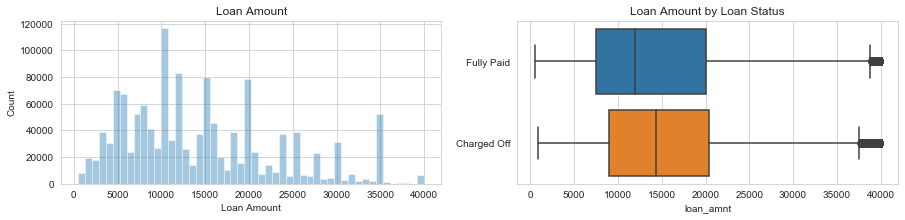

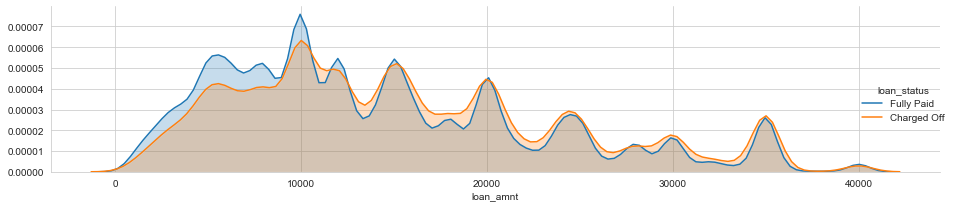

In [44]:
plot_var("loan_amnt", "Loan Amount", continuous=True)

"Charged off" loans seem to have higher loan amount. I will further examine the statistical difference in the later analysis.

# term
Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [27]:
df["term"].sample(5)

1612796     36 months
951215      36 months
1705952     60 months
1232212     60 months
903440      36 months
Name: term, dtype: object

In [28]:
df["term"].value_counts()


 36 months    1020743
 60 months     324567
Name: term, dtype: int64

In [29]:
df["term"] = df["term"].apply(lambda s: np.int8(s.split()[0]))

In [30]:
df["term"].sample(5)

1815909    36
1069574    36
456692     60
290756     36
706776     36
Name: term, dtype: int64

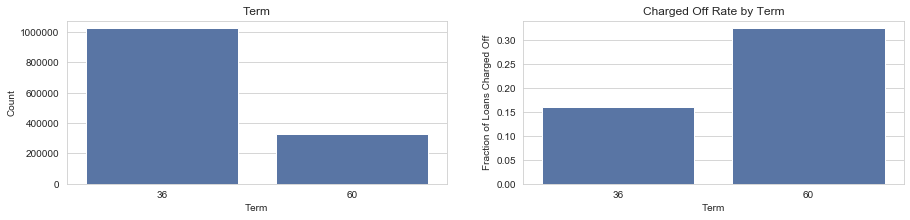

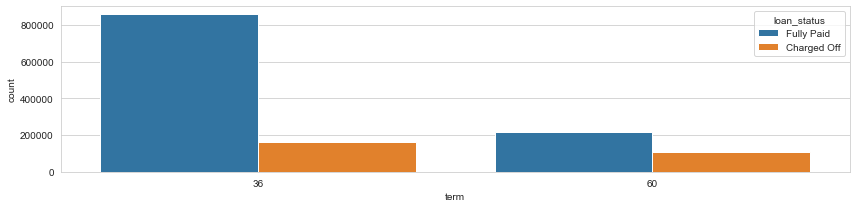

In [51]:
plot_var("term", "Term", continuous=False)

In [31]:
df["term"].value_counts(normalize=True)

36    0.758742
60    0.241258
Name: term, dtype: float64

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

Compare the charge-off rate by loan period

In [32]:
df.groupby("term")["loan_status"].value_counts(normalize=True).loc[:, "Charged Off"]


term
36    0.159934
60    0.324454
Name: loan_status, dtype: float64

16% of the 36-month loans are charge off, while 32% of the 60-month are charged off. Longer term leads to higher charged off? This feature should be useful in modeling.

# int_rate
Data Dictionary: "Interest Rate on the loan."

In [33]:
df["int_rate"].describe()

count    1.345310e+06
mean     1.323962e+01
std      4.768716e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

The interest rage ranges from 5% to 31%, with a median at 13%.

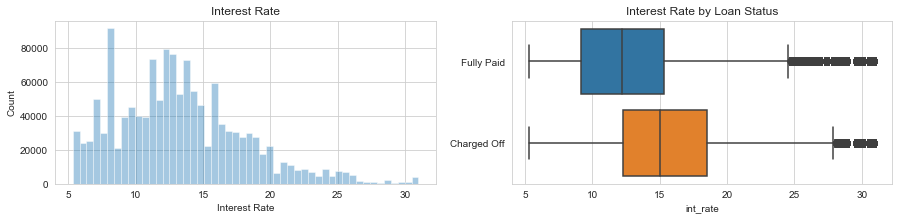

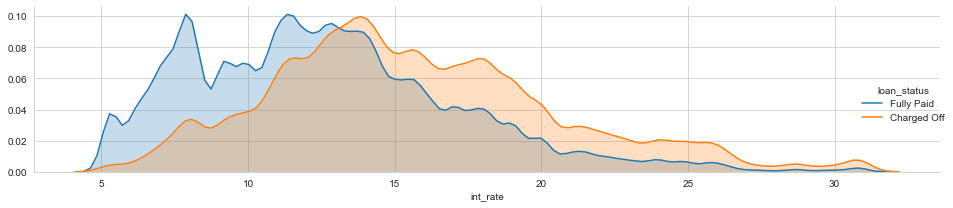

In [55]:
plot_var("int_rate", "Interest Rate", continuous=True)


The higher the interest rate is, the more likely for being charged off. There are some outliers in the Fully Paid dataset. Let's take a look at them, as outliers may distort ML analysis.

# Outliers
* outliers can be exactly what we want to learn about, e.g., anomaly detection.
* In this project, however, outliers may distort the picture of the data in both statistical analysis and visualization.
* Below, I use the modified Z-score method and the IQR method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.


In [34]:
drop_list = df.select_dtypes(exclude=['object']).columns

In [35]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding 
    to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median(
            [np.abs(y - median_y) for y in dataframe[col]]
        )
        modified_z_scores = [
            0.6745 * (y - median_y) / median_absolute_deviation_y
            for y in dataframe[col]
        ]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

In [36]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25, 75])
        # quartile_3 = np.percentile(dataframe[col], 75)

        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[
            (dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)
        ].index
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

In [37]:
df.groupby("loan_status")["int_rate"].describe()


,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15.710714,4.910387,5.31,12.29,15.05,18.55,30.99
Fully Paid,1076751.0,12.623288,4.527227,5.31,9.17,12.23,15.31,30.99


Any values > 75% percentile (18.99for "charged off", 15.31 for "Fully Paid") are defined as outliers.



In [38]:
df.loc[(df.int_rate > 15.61) & (df.loan_status == "Fully Paid")].shape[0]


234329

In [39]:
(df.loc[(df.int_rate > 15.61) & (df.loan_status == "Fully Paid")].shape[0]) / df[
    "loan_status"
].value_counts(normalize=False, dropna=False)[0]

0.21762598780962358

In [40]:
df.loc[(df.int_rate > 18.55) & (df.loan_status == "Charged Off")].shape[0] / df[
    "loan_status"
].value_counts(normalize=False, dropna=False)[1]

0.245521468280713


The percentage of outliers is roughly the same for the Fully Paid/Charged off data, ~27%. A bit too much to be dropped. We will keep these outliers for now.

# Installment
Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [41]:
df["installment"].describe()

count    1.345310e+06
mean     4.380755e+02
std      2.615126e+02
min      4.930000e+00
25%      2.484800e+02
50%      3.754300e+02
75%      5.807300e+02
max      1.719830e+03
Name: installment, dtype: float64

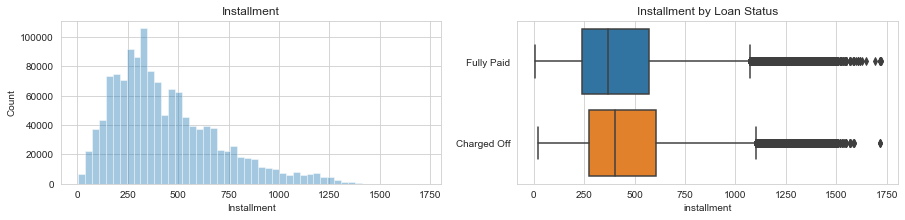

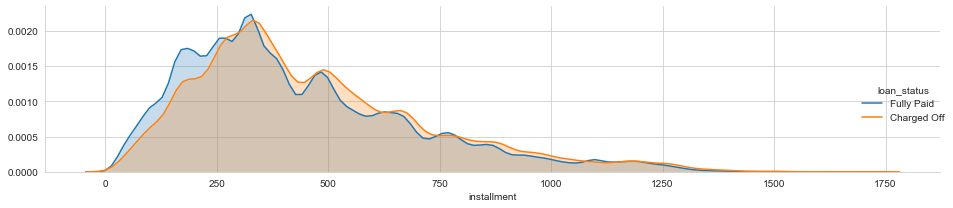

In [64]:
plot_var("installment", "Installment", continuous=True)

Charged-off loans tend to have higher installments but the difference of the mean values is very small (460 vs 431). Later, I will do a KS test to see if there are any statistical difference of "installment" between Fully Paid/charged off.

In statistics, the Kolmogorov–Smirnov test (K–S test or KS test) is a nonparametric test of the equality of continuous (or discontinuous, see Section 2.2), one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test). It is named after Andrey Kolmogorov and Nikolai Smirnov(WIKIPEDIA).

In [42]:
df.groupby("loan_status")["installment"].describe()


,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,465.147994,262.774106,21.62,275.29,402.83,605.31,1717.63
Fully Paid,1076751.0,431.323226,260.759563,4.93,240.92,368.26,573.06,1719.83


# grade, sub_grade
Data Dictionary for grade: "assigned loan grade." Data Dictionary for sub_grade: "LC assigned loan subgrade."

What are the possible values of grade and sub_grade?

In [43]:
sorted(df["grade"].unique())


['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [44]:
print(sorted(df["sub_grade"].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The "grade" is included in the "sub_grade" column, so it could be dropped.

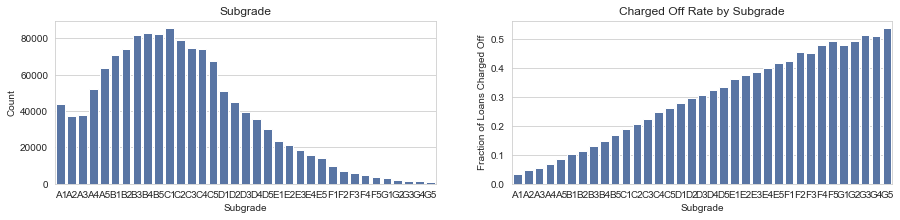

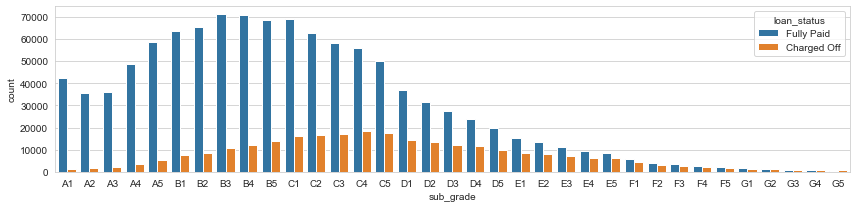

In [68]:
plot_var("sub_grade", "Subgrade", continuous=False)


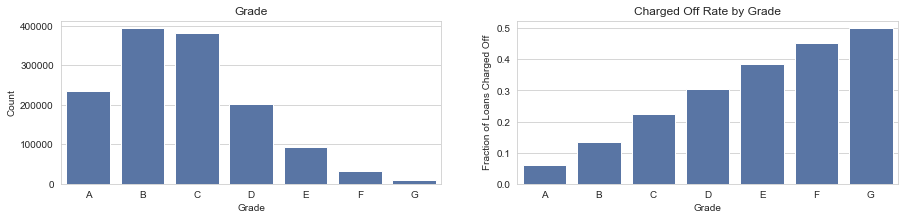

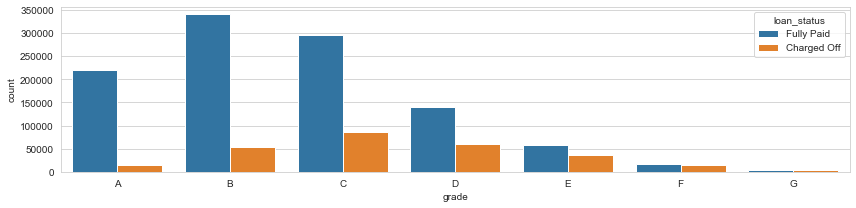

In [69]:
plot_var("grade", "Grade", continuous=False)


In [45]:
drop_cols("grade")

# emp_title
Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [46]:
df["emp_title"].describe()


count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

In [47]:
df["emp_title"].sample(5)


821096              Quality Technician
1085276    Installation Superintendent
514237               Lead Radiographer
1770093                Project Manager
1223206      Senior Programmer/Analyst
Name: emp_title, dtype: object

There are too many unique titles for this feature to be useful, so we drop this feature.



In [48]:
drop_cols("emp_title")

# emp_length
Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [49]:
df["emp_length"].value_counts(dropna=False).sort_index()

1 year        88494
10+ years    442199
2 years      121743
3 years      107597
4 years       80556
5 years       84154
6 years       62733
7 years       59624
8 years       60701
9 years       50937
< 1 year     108061
NaN           78511
Name: emp_length, dtype: int64

There are 42k loans without the information on emp_length. Convert this feature to integers.

In [50]:
df["emp_length"].replace("10+ years", "10 years", inplace=True)

In [51]:
df["emp_length"].replace("< 1 year", "0 years", inplace=True)

In [52]:
df["emp_length"].value_counts(dropna=False).sort_index()

0 years     108061
1 year       88494
10 years    442199
2 years     121743
3 years     107597
4 years      80556
5 years      84154
6 years      62733
7 years      59624
8 years      60701
9 years      50937
NaN          78511
Name: emp_length, dtype: int64

In [53]:
df.emp_length.map(lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

0      108061
1       88494
10     442199
2      121743
3      107597
4       80556
5       84154
6       62733
7       59624
8       60701
9       50937
nan     78511
Name: emp_length, dtype: int64

In [54]:
df["emp_length"] = df.emp_length.map(lambda x: float(str(x).split()[0]))

In [55]:
df["emp_length"].sample(5)

2119491    10.0
2128811     NaN
1075079     6.0
702907      NaN
1274372    10.0
Name: emp_length, dtype: float64

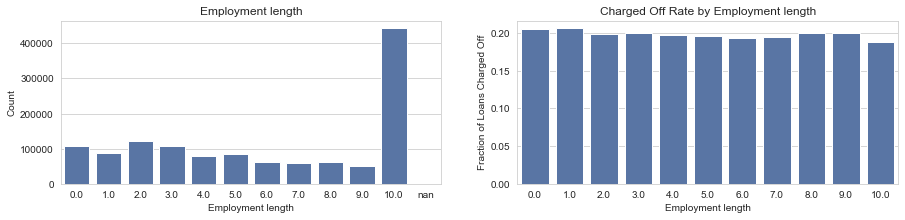

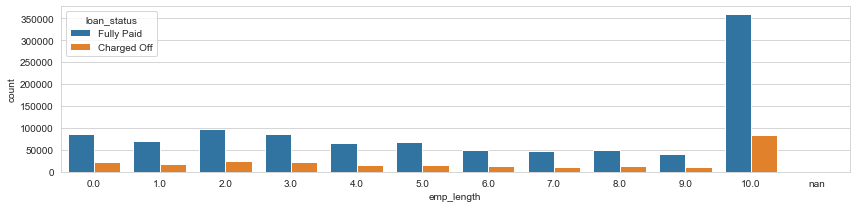

In [81]:
plot_var("emp_length", "Employment length", continuous=False)


One third of the loans go to the people with longer than 10 years of employments. However, the fully paid rate seems not quite related to this feature. Again, this will be further examined in a statistical test at the end.

# home_ownership
Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [56]:
df["home_ownership"].value_counts()

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [57]:
df["home_ownership"].replace(["NONE", "ANY"], "OTHER", inplace=True)

In [58]:
df["home_ownership"].value_counts()


MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

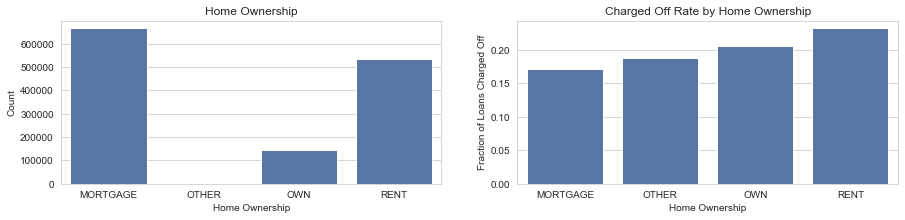

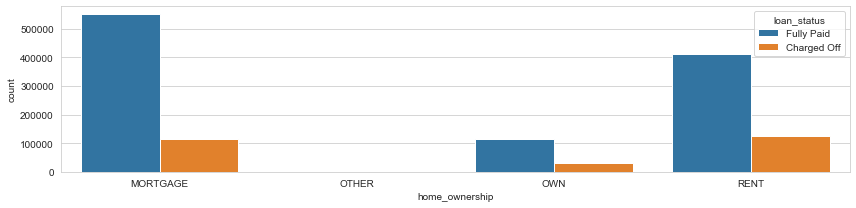

In [85]:
plot_var("home_ownership", "Home Ownership", continuous=False)

In [59]:

df.groupby("home_ownership")["loan_status"].value_counts(normalize=True).loc[
    :, "Charged Off"
]

home_ownership
MORTGAGE    0.172077
OTHER       0.188285
OWN         0.206198
RENT        0.232165
Name: loan_status, dtype: float64

There appear to be small differences in charge-off rates by home ownership status. Mortgage & OTHER has slightly less probability of Charged-Off. Because of the large numbers of observations in each category, these differences might be statistically significant.

# annual_inc
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [60]:
df["annual_inc"].describe()


count    1.345310e+06
mean     7.624764e+04
std      6.992510e+04
min      0.000000e+00
25%      4.578000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

Annual income ranges from 0 to 9M, with a median at  75k,  which doubles the national median individual income in the US  (40k  for males and 25k  for females). Due to the large range of variation, we log-transform the values.

In [61]:
df["annual_inc"] = df["annual_inc"].apply(lambda x: np.log10(x + 1))

In [62]:
df["annual_inc"].describe()

count    1.345310e+06
mean     4.812814e+00
std      2.477200e-01
min      0.000000e+00
25%      4.660685e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: annual_inc, dtype: float64

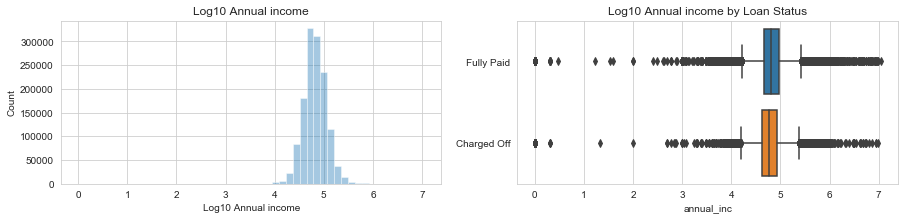

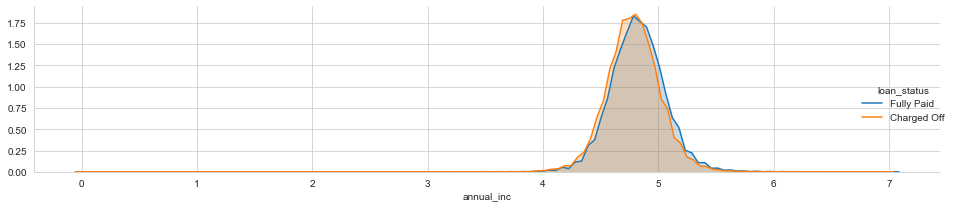

In [63]:
plot_var("annual_inc", "Log10 Annual income", continuous=True)

Let's look closer of the difference here

In [64]:
df.groupby("loan_status")["annual_inc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,4.781756,0.241984,0.0,4.633479,4.778158,4.929424,6.977724
Fully Paid,1076751.0,4.820560,0.248526,0.0,4.672107,4.812920,4.968488,7.041361


For both cases, there are quite a few outliers (in the lower end).

# verication_status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [65]:
df["verification_status"].value_counts()

Source Verified    521273
Verified           418336
Not Verified       405701
Name: verification_status, dtype: int64

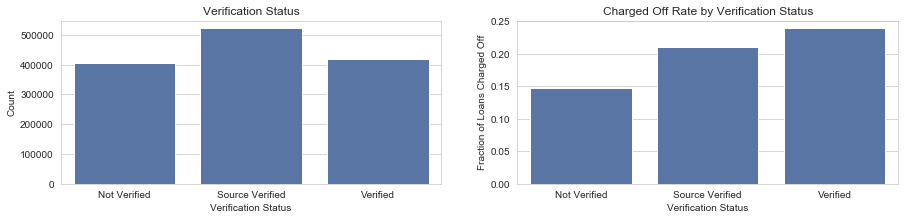

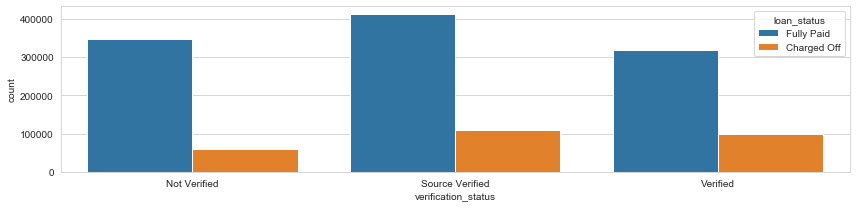

In [95]:
plot_var("verification_status", "Verification Status", continuous=False)

Surprisingly, verified loans have higher chance of being charged-Off. We would guess the opposite way.

# purpose
Data Dictionary: "A category provided by the borrower for the loan request."

In [66]:
df["purpose"].value_counts()

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, dtype: int64

In [67]:
df.groupby("purpose")["loan_status"].value_counts(normalize=True)[
    :, "Charged Off"
].sort_values(ascending=False)

purpose
small_business        0.297094
renewable_energy      0.236870
moving                0.233544
house                 0.218806
medical               0.217757
debt_consolidation    0.211469
other                 0.210401
vacation              0.191726
major_purchase        0.185998
home_improvement      0.177158
educational           0.171779
credit_card           0.169270
car                   0.146795
wedding               0.121622
Name: loan_status, dtype: float64

We see that, 30% of the loans for small_business are charged off, but only 12% of wedding are charged Off.

# title
Data Dictionary: "The loan title provided by the borrower."

In [68]:
df["title"].describe()

count                1328651
unique                 61682
top       Debt consolidation
freq                  660960
Name: title, dtype: object

In [69]:
df["title"].value_counts().head(10)

Debt consolidation         660960
Credit card refinancing    249910
Home improvement            75073
Other                       66778
Major purchase              24045
Debt Consolidation          15695
Medical expenses            13576
Business                    11750
Car financing               11220
Vacation                     8046
Name: title, dtype: int64

There are 12 unique purposes in the dataset, and from the top 10 titles, it seems that this information is covered in the "purpose". So we drop this column.

In [70]:
drop_cols("title")

# zip_code, addr_stat
Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."
Data Dictionary for addr_state: "The state provided by the borrower in the loan application."

In [71]:
df["zip_code"].describe()

count     1345309
unique        943
top         945xx
freq        15005
Name: zip_code, dtype: object

In [72]:
df["addr_state"].describe()

count     1345310
unique         51
top            CA
freq       196528
Name: addr_state, dtype: object

There are many unique "zip_code" values, and the zip_code info should be equivalent to "addr_stat". Therefore we drop the "zip_code".

In [73]:
drop_cols("zip_code")

In [74]:
df.groupby("addr_state")["loan_status"].value_counts(normalize=True)[
    :, "Charged Off"
].sort_values(ascending=False)

addr_state
MS    0.260777
NE    0.251813
AR    0.240868
AL    0.236321
OK    0.234753
LA    0.231821
NY    0.220435
NV    0.219223
FL    0.214746
IN    0.214082
TN    0.214079
NM    0.213665
SD    0.213227
MD    0.213085
MO    0.212935
NJ    0.211212
KY    0.209829
PA    0.207921
NC    0.207839
OH    0.205283
ND    0.204744
MI    0.202957
HI    0.202013
VA    0.199422
TX    0.198223
DE    0.197462
MN    0.197430
AK    0.196552
AZ    0.196299
CA    0.196104
MA    0.190528
ID    0.188277
GA    0.183927
WI    0.183510
IL    0.180974
RI    0.178675
CT    0.173763
UT    0.170586
MT    0.168716
WY    0.167693
KS    0.167438
SC    0.162769
WA    0.157565
CO    0.155269
WV    0.155187
NH    0.145759
OR    0.143850
IA    0.142857
VT    0.139517
ME    0.138424
DC    0.132086
Name: loan_status, dtype: float64

MS has the highest fraction of Charged Off (0.28), whereas DC has the lowest fraction at 0.13.

# dti
Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [75]:
df["dti"].describe()

count    1.344936e+06
mean     1.828267e+01
std      1.116045e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.406000e+01
max      9.990000e+02
Name: dti, dtype: float64

The values of -1 or 999 are probably outliers. Let's look at its histogram .

Text(0.5, 1.0, 'DTI by loan status')

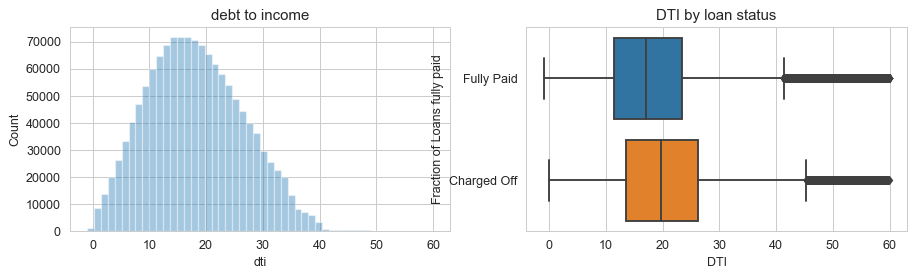

In [106]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)
sns.distplot(df.loc[df["dti"].notnull() & (df["dti"] < 60), "dti"], kde=False, ax=ax1)
ax1.set_xlabel("dti")
ax1.set_ylabel("Count")
ax1.set_title("debt to income")
sns.boxplot(
    x=df.loc[df["dti"].notnull() & (df["dti"] < 60), "dti"],
    y="loan_status",
    data=df,
    ax=ax2,
)
ax2.set_xlabel("DTI")
ax2.set_ylabel("Fraction of Loans fully paid")
ax2.set_title("Fully paid rate by debt to income")
ax2.set_title("DTI by loan status")

In [76]:
(df["dti"] > 40).sum() / (df["dti"]).sum()

0.0002751635018498183

In [77]:
(df["dti"] > 40).sum()

6766

Very few (0.01%) outliers with dti > 60. From the figure it seems that the Charged Off loans have higher DTI. Let's check.

In [78]:
df.groupby("loan_status")["dti"].median()

loan_status
Charged Off    19.76
Fully Paid     17.11
Name: dti, dtype: float64

It's clear that borrowers who have higher DTI are more likely to be charged off.

# open_acc
Data Dictionary: "The number of open credit lines in the borrower's credit file."

In [79]:
df["open_acc"].describe()

count    1.345310e+06
mean     1.159352e+01
std      5.473789e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: open_acc, dtype: float64

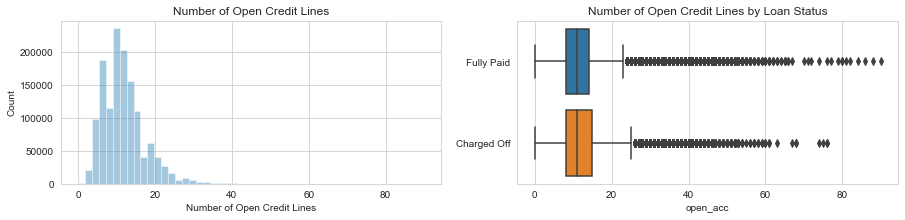

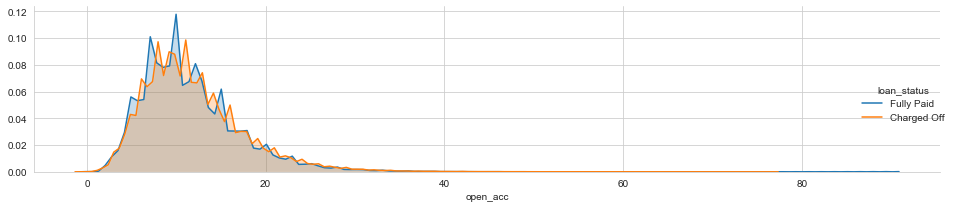

In [111]:
plot_var("open_acc", "Number of Open Credit Lines", continuous=True)

There seems no significant difference in number of credit lines between fully paid loans and charged-off loans.

In [80]:
df.groupby("loan_status")["open_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,11.901269,5.637964,0.0,8.0,11.0,15.0,76.0
Fully Paid,1076751.0,11.516763,5.429354,0.0,8.0,11.0,14.0,90.0


# earliest_cr_line
Data Dictionary: "The month the borrower's earliest reported credit line was opened."

Rather than converting it to a date, I will use a scalar to describe the length of time since the first line of credit. If all other variables are held equal, the longer you have had lines of credit the better.

In [81]:
df["earliest_cr_line"].sample(5)

197683     Jun-1988
1329201    Oct-1997
97913      Oct-2000
1078481    Mar-2005
2070947    Sep-2006
Name: earliest_cr_line, dtype: object

In [82]:
df["earliest_cr_line"].describe()

count      1345310
unique         739
top       Aug-2001
freq          9391
Name: earliest_cr_line, dtype: object

In [83]:
df["earliest_cr_line"].isnull().any()

False

In [84]:
from datetime import datetime

df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

dttoday = datetime.now().strftime("%Y-%m-%d")
df.earliest_cr_line = df.earliest_cr_line.apply(
    lambda x: (np.timedelta64((x - pd.Timestamp(dttoday)), "D").astype(int)) / -365
)

df.earliest_cr_line.shape

(1345310,)

In [85]:
df.earliest_cr_line.sample(5)

1678885    24.397260
1068819    17.893151
1015720    13.224658
203649     17.312329
183437     15.057534
Name: earliest_cr_line, dtype: float64

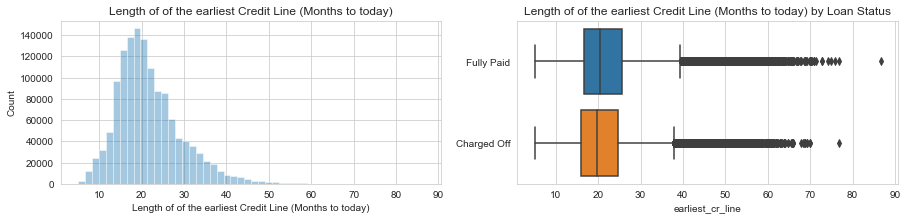

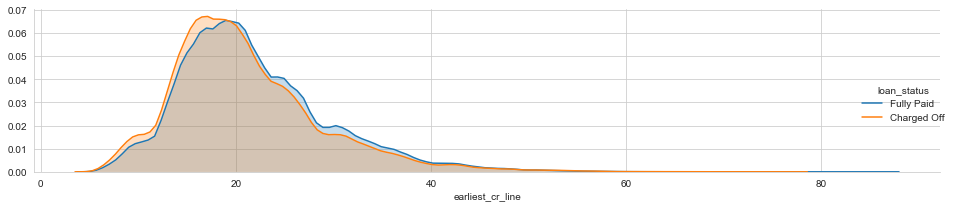

In [86]:
plot_var(
    "earliest_cr_line",
    "Length of of the earliest Credit Line (Months to today)",
    continuous=True,
)

Borrowers who charged off have opened their first credit line more recently, although their medians are almost the same.

In [86]:
df.groupby("loan_status")["earliest_cr_line"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,20.970109,7.583253,5.219178,15.890411,19.646575,24.728767,76.849315
Fully Paid,1076751.0,21.808311,7.613510,5.052055,16.558904,20.394521,25.728767,86.608219



# fico_range_low, fico_range_high
Data Dictionary for fico_range_low: "The lower boundary range the borrower’s FICO at loan origination belongs to."
Data Dictionary for fico_range_high: "The upper boundary range the borrower’s FICO at loan origination belongs to."

FICO: A FICO score is a type of credit score created by the Fair Isaac Corporation. Lenders use borrowers' FICO scores along with other details on borrowers' credit reports to assess credit risk and determine whether to extend credit. FICO scores take into account various factors in five areas to determine creditworthiness: payment history, current level of indebtedness, types of credit used, length of credit history, and new credit accounts.

In [87]:
df[["fico_range_low", "fico_range_high"]].describe()

,fico_range_low,fico_range_high
count,1.345310e+06,1.345310e+06
mean,6.961850e+02,7.001852e+02
std,3.185251e+01,3.185316e+01
min,6.250000e+02,6.290000e+02
25%,6.700000e+02,6.740000e+02
50%,6.900000e+02,6.940000e+02
75%,7.100000e+02,7.140000e+02
max,8.450000e+02,8.500000e+02


Check the correlation between the two:

In [88]:
df[["fico_range_low", "fico_range_high"]].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


These two are highly correlated, therefore we only need to keep one. We create a new feature, "fico_score" which is the mean value of the "fico_range_low" and "fico_range_high"

In [89]:
df["fico_score"] = (df["fico_range_low"] + df["fico_range_high"]) / 2.0

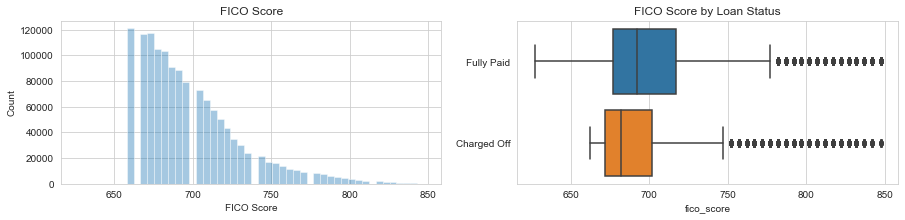

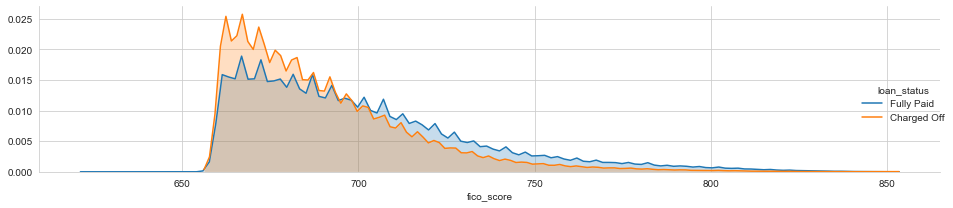

In [124]:
plot_var("fico_score", "FICO Score", continuous=True)


There is noticeable difference in FICO scores between fully paid and charged-off loans.

Thought 1: A side note, what are the missing values in the specific FICO scores (i.e., ~620, 700, 730)? where are they from?

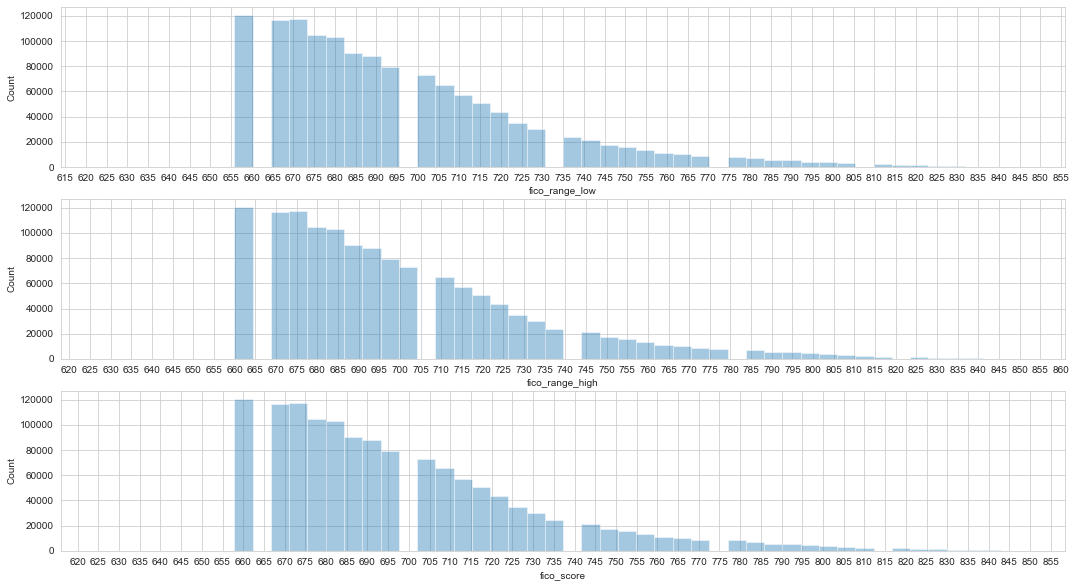

In [90]:
import matplotlib.ticker as ticker

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(18, 10))
sns.distplot(
    df.loc[df["fico_range_low"].notnull(), "fico_range_low"], kde=False, ax=ax1
)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.set_ylabel("Count")

sns.distplot(
    df.loc[df["fico_range_high"].notnull(), "fico_range_high"], kde=False, ax=ax2
)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.set_ylabel("Count")

sns.distplot(df.loc[df["fico_score"].notnull(), "fico_score"], kde=False, ax=ax3)
ax3.set_ylabel("Count")
ax3.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [91]:
df["fico_range_low"].value_counts().sort_index().head(5)

625.0         1
630.0         1
660.0    120862
665.0    116821
670.0    117202
Name: fico_range_low, dtype: int64

In [92]:
df["fico_range_high"].value_counts().sort_index().head(5)

629.0         1
634.0         1
664.0    120862
669.0    116821
674.0    117202
Name: fico_range_high, dtype: int64

In [93]:
df["fico_score"].value_counts().sort_index().head(5)

627.0         1
632.0         1
662.0    120862
667.0    116821
672.0    117202
Name: fico_score, dtype: int64

Thought 2: As FICO score itself stands out as an overall important factor. I would like to check the most significant contributors (acct number, earliest credit card, and the ratio of total monthly debt payments on the total debt obligations) to the FICO score, based on my own knowledge.

In [94]:
df[["fico_score", "open_acc", "earliest_cr_line", "dti"]].corr()

,fico_score,open_acc,earliest_cr_line,dti
fico_score,1.000000,0.017426,0.098915,-0.061928
open_acc,0.017426,1.000000,0.128078,0.224891
earliest_cr_line,0.098915,0.128078,1.000000,0.021260
dti,-0.061928,0.224891,0.021260,1.000000


In [95]:
plot_df = df.query("fico_score > 650")[:3000]

Text(0.5, 0, 'fico_score')

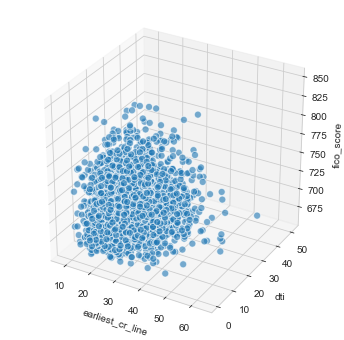

In [96]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121, projection="3d")

xs = plot_df["earliest_cr_line"]
ys = plot_df["dti"]
zs = plot_df["fico_score"]
ax1.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors="w", cmap="greens")

ax1.set_xlabel("earliest_cr_line")
ax1.set_ylabel("dti")
ax1.set_zlabel("fico_score")

Text(0.5, 1.05, 'Fico_score - earliest_cr_line - DTI')

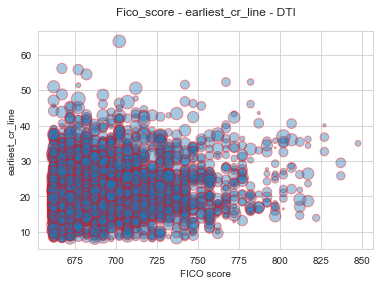

In [97]:

%matplotlib inline
import matplotlib.pyplot as plt

# Visualizing 3-D numeric data with a bubble chart
plt.scatter(zs, xs, s=ys * 5, alpha=0.4, edgecolors="red")

plt.xlabel("FICO score")
plt.ylabel("earliest_cr_line")
plt.title("Fico_score - earliest_cr_line - DTI", y=1.05)

Thought 3: As we know that FICO score is a very important feature, we would like to check the correlations between FICO score, int_rate and the term, 3 of the most important features that show different distributions between "Charged-off" and "fully paid" loans from previous EDA.

In [98]:
df[["fico_score", "int_rate", "term"]].corr()

,fico_score,int_rate,term
fico_score,1.000000,-0.405365,-0.002222
int_rate,-0.405365,1.000000,0.417230
term,-0.002222,0.417230,1.000000


It seems that the higher the fico_score is, the lower the int_rate. Let's take a look at their correlations.

In [99]:
drop_cols(["fico_range_high", "fico_range_low"])

# pub_rec
Data Dictionary: "Number of derogatory public records."

In [100]:
df["pub_rec"].describe()

count    1.345310e+06
mean     2.152760e-01
std      6.018647e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

In [101]:
df["pub_rec"].value_counts().sort_values(ascending=False)

0.0     1117425
1.0      190789
2.0       24435
3.0        7399
4.0        2630
5.0        1266
6.0         636
7.0         283
8.0         160
9.0          83
10.0         57
11.0         40
12.0         27
13.0         18
15.0          9
21.0          6
18.0          6
14.0          5
16.0          5
19.0          5
17.0          3
28.0          3
20.0          3
49.0          2
24.0          2
22.0          2
37.0          1
23.0          1
40.0          1
46.0          1
47.0          1
25.0          1
54.0          1
61.0          1
63.0          1
86.0          1
34.0          1
Name: pub_rec, dtype: int64

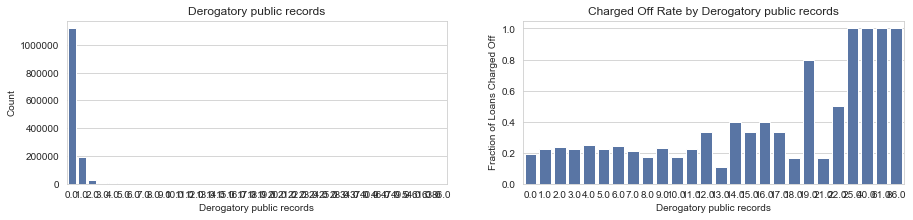

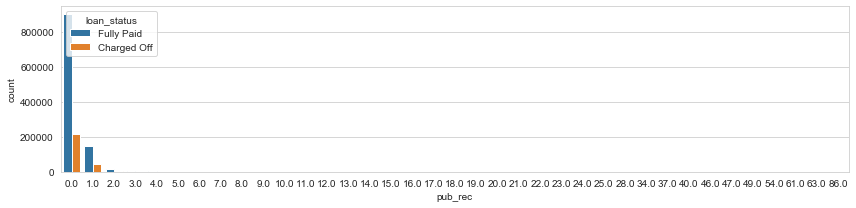

In [104]:
plot_var("pub_rec", "Derogatory public records", continuous=False)

"pub_rec" > 11 have significant of Charged-Off rate. However, it's affected by low-counts. If we look at the overall statistics, the mean difference in "pub_Rec" is just 0.04 for fully paid/charged Off

In [102]:
df.groupby("loan_status")["pub_rec"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,0.246843,0.656732,0.0,0.0,0.0,0.0,86.0
Fully Paid,1076751.0,0.207403,0.587118,0.0,0.0,0.0,0.0,63.0


In [103]:
df.pub_rec = df.pub_rec.map(lambda x: 3 if x > 2.0 else x)

In [104]:
df["pub_rec"].value_counts().sort_values(ascending=False)

0.0    1117425
1.0     190789
2.0      24435
3.0      12661
Name: pub_rec, dtype: int64

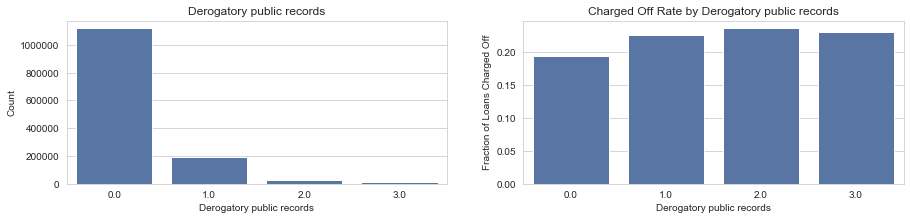

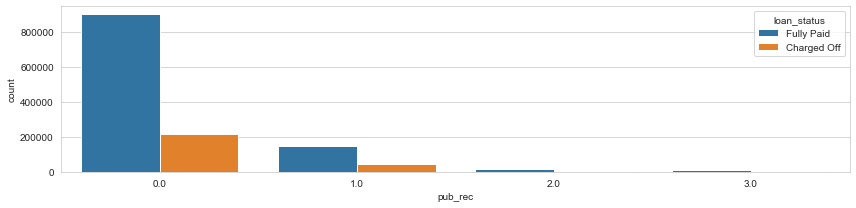

In [108]:
plot_var("pub_rec", "Derogatory public records", continuous=False)

In [105]:
df.groupby("loan_status")["pub_rec"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,0.236347,0.537366,0.0,0.0,0.0,0.0,3.0
Fully Paid,1076751.0,0.198903,0.498270,0.0,0.0,0.0,0.0,3.0


After grouping, it is clear that: pub_rec are mostly 0 & 1; pub_rec with 1 and higher have higher chance of being charged off than pub_rec of 0.

# pub_rec_bankruptcies
Data Dictionary: "Number of public record bankruptcies."

In [106]:
df[["pub_rec", "pub_rec_bankruptcies"]].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.735344
pub_rec_bankruptcies,0.735344,1.000000


"pub_rec" and "pub_rec_bankruptcies" are highly correlated. could only feed one of them into the modeling.

# revol_bal
Data Dictionary: "Total credit revolving balance."

In [107]:
df["revol_bal"].describe()

count    1.345310e+06
mean     1.624811e+04
std      2.232817e+04
min      0.000000e+00
25%      5.943000e+03
50%      1.113400e+04
75%      1.975575e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

In [108]:
df["revol_bal"] = df["revol_bal"].apply(lambda x: np.log10(x + 1))

In [109]:
# plot_var("revol_bal", "Log10 total credit revolving balance", continuous=True)

# revol_util
Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [110]:
# plot_var("revol_util", "Revolving line utilization rate", continuous=True)

In [111]:
df.groupby("loan_status")["revol_util"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268379.0,54.758433,23.865982,0.0,37.4,55.5,73.1,366.6
Fully Paid,1076074.0,51.074671,24.626821,0.0,32.5,51.3,70.1,892.3


Charged Off loans tend to have higher revol_util.

# total_acc
Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

In [112]:
df["total_acc"].describe()

count    1.345310e+06
mean     2.498084e+01
std      1.199847e+01
min      2.000000e+00
25%      1.600000e+01
50%      2.300000e+01
75%      3.200000e+01
max      1.760000e+02
Name: total_acc, dtype: float64

In [113]:
# plot_var("total_acc", "total number of credit lines", continuous=True)

# initial_list_status
Data Dictionary: "The initial listing status of the loan. Possible values are – W, F (whole vs. fractional)

In [114]:
df["initial_list_status"].value_counts()

w    784010
f    561300
Name: initial_list_status, dtype: int64

Half of the granted loans are in whole amount and half are in fractional amount. "Whole" has higher fraction of Charged-Off.

In [115]:
# plot_var("initial_list_status", "Initial listing status of the loan", continuous=False)

# policy_code
Data Dictionary: "publicly available policy_code=1; new products not publicly available policy_code=2"

In [116]:
df["policy_code"].value_counts()

1.0    1345310
Name: policy_code, dtype: int64

All values are the same; drop this feature.

In [117]:
drop_cols("policy_code")

# application_type
Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [118]:
df["application_type"].value_counts()

Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

The majority of the loans are individual applications and they are more possible to be charged off than joint app.

# mo_sin_old_il_acct
Data Dictionary: "Months since oldest bank installment account opened."

In [119]:
df["mo_sin_old_il_acct"].describe()

count    1.239735e+06
mean     1.257976e+02
std      5.223336e+01
min      0.000000e+00
25%      9.800000e+01
50%      1.290000e+02
75%      1.520000e+02
max      9.990000e+02
Name: mo_sin_old_il_acct, dtype: float64

# mo_sin_old_rev_tl_op
Data Dictionary: "Months since oldest revolving account opened."

In [120]:
df["mo_sin_old_rev_tl_op"].describe()

count    1.277782e+06
mean     1.814760e+02
std      9.450512e+01
min      2.000000e+00
25%      1.170000e+02
50%      1.640000e+02
75%      2.300000e+02
max      8.520000e+02
Name: mo_sin_old_rev_tl_op, dtype: float64

# mort_acc
Data Dictionary: "Number of mortgage accounts."

In [121]:
df["mort_acc"].describe()

count    1.298029e+06
mean     1.670783e+00
std      2.000444e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

In [122]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

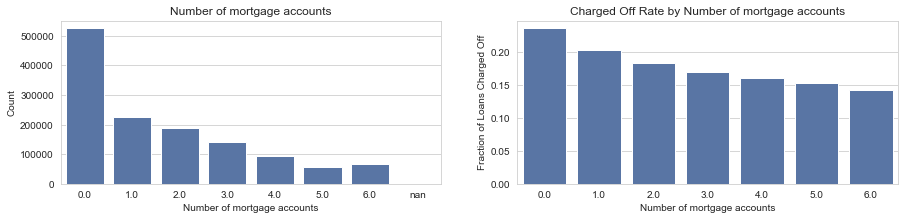

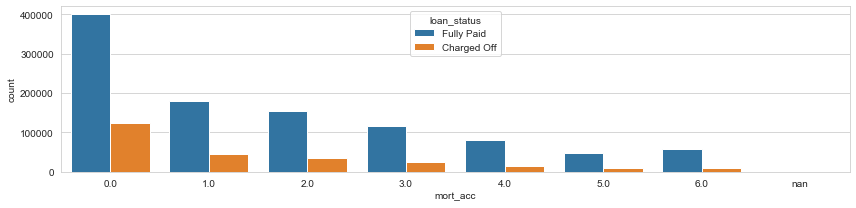

In [127]:
plot_var("mort_acc", "Number of mortgage accounts", continuous=False)


The more the number of mortgage accounts, the lower fraction of loans charged off.

In [123]:
df.groupby("loan_status")["mort_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261673.0,1.332598,1.683164,0.0,0.0,1.0,2.0,6.0
Fully Paid,1036356.0,1.683199,1.830426,0.0,0.0,1.0,3.0,6.0


# 4.4 remove irelevent features!
Besides the formentioned points after culling the NaN dominated columns, there are still a lot of features. Some will have useful info, others not. At this point I will carefully inspect the remaining features and weeded out any column that I think may be well useless. My main criteria is whether a feature is dominated by a single value (> 80%)

1. addr_state: We really don't think that the state and location of aperson will determine if they will repay a loan. Although, I could be wrong ....
2. application_type: was >99% INDIVIDUAL

In [124]:
del_cols = [
    "addr_state",
    "application_type",
]
df.shape

(1345310, 27)

In [125]:
drop_cols(del_cols)
df.shape

(1345310, 25)

# 5 Feature Selection II: Statistical Overview
We have looked at the features individually. Now We will do some overall statistical tests for all the features on their distributions, correlations, etc.

# 5.1 Convert target variable to 0/1 indicator
It's more convenient/useful to convert our target variable to numerical variable. Fully Paid = 0, Charged Off = 1

In [126]:
df["Charged_Off"] = df["loan_status"].apply(lambda s: np.float(s == "Charged Off"))
drop_cols("loan_status")


# 5.2 Hypothesis Testing

Here I can group the loans to "fully paid" & "charged-off", and then use hypothesis tests to compare the two distributions of each feature.

If the test statistic is small or the p-value is high (>0.05, 95% confidence level), we cannot reject the null hypothesis that the distributions of the two samples are the same and if if p<0.05, different distributions.

K-S Tests, Z Tests and chi-squared Tests:

* Numerical features: We can use K-S tests
* Features with only 0 or 1 values, we can use proportion Z tests to check whether the difference in mean values is statistically significant.
* For categorical features, we can use chi-squared Tests

In [127]:
list_float = df.select_dtypes(exclude=["object"]).columns

In [128]:
def run_KS_test(feature):
    dist1 = df.loc[df.Charged_Off == 0, feature]
    dist2 = df.loc[df.Charged_Off == 1, feature]
    print(feature + ":")
    print(ks_2samp(dist1, dist2), "\n")

In [129]:
from statsmodels.stats.proportion import proportions_ztest


def run_proportion_Z_test(feature):
    dist1 = df.loc[df.Charged_Off == 0, feature]
    dist2 = df.loc[df.Charged_Off == 1, feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature + ":")
    print("z-score = {}; p-value = {}".format(z_score, p_value), "\n")

In [130]:
def run_chi2_test(df, feature):

    dist1 = (
        df.loc[df.loan_status == "Fully Paid", feature]
        .value_counts()
        .sort_index()
        .tolist()
    )
    dist2 = (
        df.loc[df.loan_status == "Charged Off", feature]
        .value_counts()
        .sort_index()
        .tolist()
    )
    chi2, p, dof, expctd = chi2_contingency([dist1, dist2])
    print(feature + ":")
    print("chi-square test statistic:", chi2)
    print("p-value", p, "\n")

In [131]:
for i in list_float:
    run_KS_test(i)

loan_amnt:
Ks_2sampResult(statistic=0.08341793565761396, pvalue=0.0) 

term:
Ks_2sampResult(statistic=0.1884875690616944, pvalue=0.0) 

int_rate:
Ks_2sampResult(statistic=0.26709123944420854, pvalue=0.0) 

installment:
Ks_2sampResult(statistic=0.07177308649462699, pvalue=0.0) 

emp_length:
Ks_2sampResult(statistic=0.02538830065622577, pvalue=9.11735879570968e-121) 

annual_inc:
Ks_2sampResult(statistic=0.07162968406367032, pvalue=0.0) 

dti:
Ks_2sampResult(statistic=0.11413770318986116, pvalue=0.0) 

earliest_cr_line:
Ks_2sampResult(statistic=0.05478115417211504, pvalue=0.0) 

open_acc:
Ks_2sampResult(statistic=0.02923793065231428, pvalue=4.9928027835478835e-160) 

pub_rec:
Ks_2sampResult(statistic=0.029598859981289527, pvalue=5.414690789546113e-164) 

revol_bal:
Ks_2sampResult(statistic=0.018292907328583796, pvalue=6.685708285584415e-63) 

revol_util:
Ks_2sampResult(statistic=0.06461830322886436, pvalue=0.0) 

total_acc:
Ks_2sampResult(statistic=0.017750078823176307, pvalue=3.00597132

OK, it seems that all of these features have different distributions for Fully Paid/Charged Off.

# 5.3 Pearson Correlation

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  int64  
 2   int_rate              1345310 non-null  float64
 3   installment           1345310 non-null  float64
 4   sub_grade             1345310 non-null  object 
 5   emp_length            1266799 non-null  float64
 6   home_ownership        1345310 non-null  object 
 7   annual_inc            1345310 non-null  float64
 8   verification_status   1345310 non-null  object 
 9   issue_d               1345310 non-null  object 
 10  purpose               1345310 non-null  object 
 11  dti                   1344936 non-null  float64
 12  earliest_cr_line      1345310 non-null  float64
 13  open_acc              1345310 non-null  float64
 14  pub_rec               1345310 non-

In [133]:
list_float = df.select_dtypes(exclude=["object"]).columns

In [134]:
list_float

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'fico_score', 'Charged_Off'],
      dtype='object')

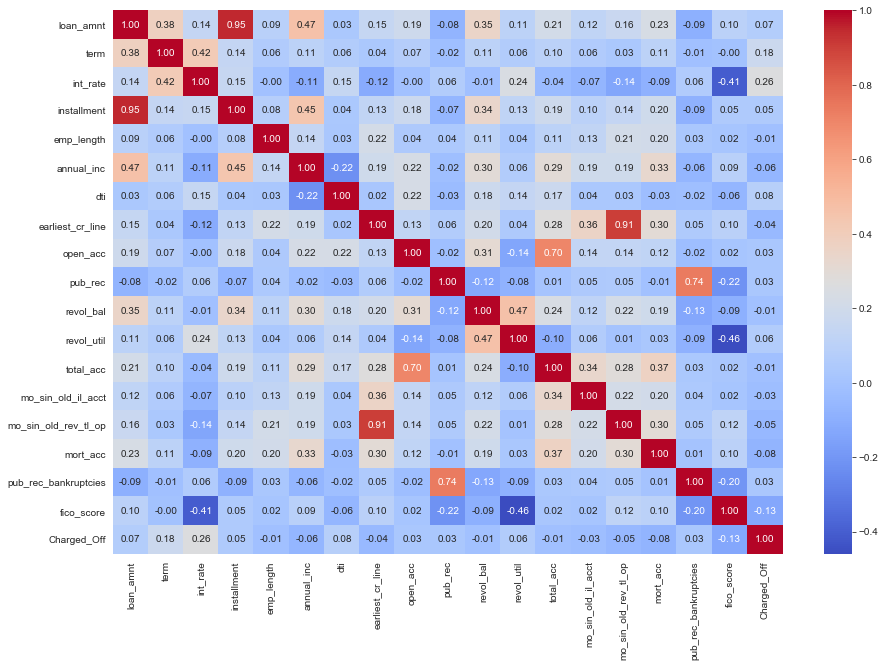

In [139]:
fig, ax = plt.subplots(figsize=(15, 10))  # Sample figsize in inches
cm_df = sns.heatmap(
    df[list_float].corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax
)

The linearly correlated features are:

* "installment" vs "loan_amnt" (0.95)
* "mo_sin_old_rev_tl_op"* vs "earliest_cr_line" (0.91)
* "pub_rec_bankruptcies"* vs "pub_rec" (0.75)
* "total_acc" vs "open_acc" (0.69)
* (*) with null values
* Dependence of Charged-off on the predictors: "int_rate" is the most correlated one. (Also see the Table1)

In [135]:
cor = df[list_float].corr()
cor.loc[:, :] = np.tril(cor, k=-1)  # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

term                  loan_amnt               0.380905
int_rate              loan_amnt               0.141673
                      term                    0.417230
installment           loan_amnt               0.953401
                      term                    0.142858
                      int_rate                0.153916
annual_inc            loan_amnt               0.467449
                      term                    0.110195
                      int_rate               -0.110495
                      installment             0.446577
                      emp_length              0.141036
dti                   int_rate                0.146886
                      annual_inc             -0.223908
earliest_cr_line      loan_amnt               0.150126
                      int_rate               -0.116265
                      installment             0.131005
                      emp_length              0.216147
                      annual_inc              0.194459
open_acc  

In [136]:
df[
    [
        "installment",
        "loan_amnt",
        "mo_sin_old_rev_tl_op",
        "earliest_cr_line",
        "total_acc",
        "open_acc",
        "pub_rec_bankruptcies",
        "pub_rec",
    ]
].isnull().any()

installment             False
loan_amnt               False
mo_sin_old_rev_tl_op     True
earliest_cr_line        False
total_acc               False
open_acc                False
pub_rec_bankruptcies     True
pub_rec                 False
dtype: bool

In [137]:
list_linear = [
    "installment",
    "mo_sin_old_rev_tl_op",
    "total_acc",
    "pub_rec_bankruptcies",
]

In [138]:
linear_corr = pd.DataFrame()

In [139]:
# Pearson coefficients
for col in df[list_float].columns:
    linear_corr.loc[col, "pearson_corr"] = df[col].corr(df["Charged_Off"])
linear_corr["abs_pearson_corr"] = abs(linear_corr["pearson_corr"])

Sort the results by the absolute value of the Pearson Correlation

In [140]:
linear_corr.sort_values("abs_pearson_corr", ascending=False, inplace=True)
linear_corr.drop("abs_pearson_corr", axis=1, inplace=True)
linear_corr.drop("Charged_Off", axis=0, inplace=True)

In [141]:
linear_corr.reset_index(inplace=True)
# linear_corr.rename(columns={'index':'variable'}, inplace=True

Table 1:

In [142]:
linear_corr

,index,pearson_corr
0,int_rate,0.258792
1,term,0.176096
2,fico_score,-0.130683
3,dti,0.084510
4,mort_acc,-0.077832
5,loan_amnt,0.065604
6,annual_inc,-0.062614
7,revol_util,0.060048
8,installment,0.051701
9,mo_sin_old_rev_tl_op,-0.050502


The variables most linearly correlated with our target variable are interest rate, loan term, Fico Score and debt-to-income ratio. The least correlated features are the revolving balance, employment length, and public record.

In [143]:
# Drop the linear correlated features
drop_cols(list_linear)

In [144]:
list_linear

['installment', 'mo_sin_old_rev_tl_op', 'total_acc', 'pub_rec_bankruptcies']

# 6. Feature Engineering
We are going to further cleaning the remaining data and get them ready for machine learning.

* One-Hot Encoding
* Train/Test Split
* Imputing missing values
* Scaling
* PCA
* Linear Dependence of the Charged-Off

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1345310 non-null  float64
 1   term                 1345310 non-null  int64  
 2   int_rate             1345310 non-null  float64
 3   sub_grade            1345310 non-null  object 
 4   emp_length           1266799 non-null  float64
 5   home_ownership       1345310 non-null  object 
 6   annual_inc           1345310 non-null  float64
 7   verification_status  1345310 non-null  object 
 8   issue_d              1345310 non-null  object 
 9   purpose              1345310 non-null  object 
 10  dti                  1344936 non-null  float64
 11  earliest_cr_line     1345310 non-null  float64
 12  open_acc             1345310 non-null  float64
 13  pub_rec              1345310 non-null  float64
 14  revol_bal            1345310 non-null  float64
 15

In [146]:
df.sample(5)

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,mo_sin_old_il_acct,mort_acc,fico_score,Charged_Off
416444,1400.0,36,16.49,D3,8.0,MORTGAGE,4.986776,Not Verified,Jan-2015,medical,11.95,20.312329,10.0,0.0,3.737034,52.5,f,112.0,1.0,662.0,0.0
1855064,12800.0,36,6.62,A2,10.0,MORTGAGE,5.021193,Not Verified,Apr-2013,debt_consolidation,5.91,23.564384,9.0,0.0,4.162982,40.6,w,94.0,4.0,717.0,0.0
1800759,2800.0,36,13.68,C1,10.0,MORTGAGE,4.716012,Verified,Sep-2013,debt_consolidation,9.23,22.397260,15.0,1.0,3.930643,27.7,f,126.0,6.0,677.0,0.0
1103946,28000.0,36,5.32,A1,4.0,MORTGAGE,5.220111,Source Verified,Jan-2016,home_improvement,15.45,26.065753,13.0,0.0,4.054307,22.4,w,147.0,5.0,772.0,0.0
1319582,4500.0,36,14.16,C2,NaN,MORTGAGE,4.505164,Source Verified,Mar-2014,debt_consolidation,21.01,19.561644,9.0,1.0,3.869056,64.3,f,126.0,1.0,662.0,0.0


In [147]:
missing_values_table(df)

Your selected dataframe has 21 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values,type
mo_sin_old_il_acct,105575,7.8,float64
emp_length,78511,5.8,float64
mort_acc,47281,3.5,float64
revol_util,857,0.1,float64
dti,374,0.0,float64


There are 5 variables with missing values (with very small percentage). They are not categorical variables.

# 6.1 Categorical Variables

In [148]:
dummy_list = [
    "sub_grade",
    "home_ownership",
    "verification_status",
    "purpose",
    # "addr_state",
    "initial_list_status",
    # "application_type",
]

In [149]:
df[dummy_list].isnull().any()


sub_grade              False
home_ownership         False
verification_status    False
purpose                False
initial_list_status    False
dtype: bool

In [150]:
df = pd.get_dummies(df, columns=dummy_list, drop_first=True)

In [151]:
df.shape

(1345310, 69)

In [152]:
df.head(1)

,loan_amnt,term,int_rate,emp_length,annual_inc,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,mo_sin_old_il_acct,mort_acc,fico_score,Charged_Off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,3600.0,36,13.99,10.0,4.740371,Dec-2015,5.91,17.227397,7.0,0.0,3.441852,29.7,148.0,1.0,677.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


Looks good. all data are numerical, except "issue_d", which we will use to split test/train sample and then it will be dropped.

# 6.2 Train/Test data split

I will use loans funded on earlier dates to predict the outcome of loans funded on later dates.

In [153]:
df["issue_d"].sample(1)

1248970    Jul-2014
Name: issue_d, dtype: object

In [154]:
df["issue_d"].isnull().any()

False

In [155]:
df["issue_d"] = pd.to_datetime(df["issue_d"])

In [156]:
df["issue_d"].sample()

1943119   2016-09-01
Name: issue_d, dtype: datetime64[ns]

In [157]:
df["issue_d"].describe()

count                 1345310
unique                    139
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

There are 124 unique values. The first loans were issued in Jan 2007 and the last loans were issued in September 2018. The busiest month was Oct 2014-2015, with ~35000 loans funded in that month. Let's further check the distribution of loans funded per month.

Text(0.5, 1.0, 'Loans funded per Year')

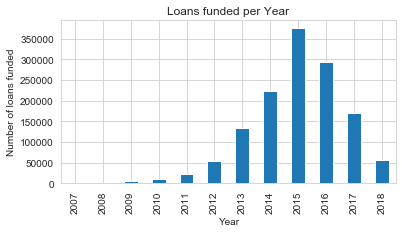

In [158]:
plt.figure(figsize=(6, 3))
df["issue_d"].dt.year.value_counts().sort_index().plot.bar()
plt.xlabel("Year")
plt.ylabel("Number of loans funded")
plt.title("Loans funded per Year")


Interestingly, the funded loans significantly increased since 2013, and continued through 2015.

We will split the train/test sample at 8:2

In [159]:
df_train = df.loc[df["issue_d"] < df["issue_d"].quantile(0.8)]
df_test = df.loc[df["issue_d"] >= df["issue_d"].quantile(0.8)]

In [160]:
print("Number of loans in the partition:   ", df_train.shape[0] + df_test.shape[0])
print("Number of loans in the full dataset:", df.shape[0])

Number of loans in the partition:    1345310
Number of loans in the full dataset: 1345310


Let's look at the summary statistics of the issue dates in the train/test sets.


In [161]:
df_train["issue_d"].describe()

count                 1062374
unique                    112
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2016-09-01 00:00:00
Name: issue_d, dtype: object

In [162]:
df_test["issue_d"].describe()

count                  282936
unique                     27
top       2016-12-01 00:00:00
freq                    19373
first     2016-10-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [163]:
df_train.drop("issue_d", axis=1, inplace=True)
df_test.drop("issue_d", axis=1, inplace=True)

Now separate the predictor variables from the target variable

In [164]:
X_train = df_train.drop(["Charged_Off"], axis=1).copy()
y_train = df_train.loc[:, "Charged_Off"]

X_test = df_test.drop(["Charged_Off"], axis=1)
y_test = df_test["Charged_Off"]

In [165]:
X_all = df.drop(["Charged_Off"], axis=1)
Y_all = df.loc[:, "Charged_Off"]

# 6.3 Imputing missing values

I will create an imputer object with the strategy set to median. I then train this object on the training data and use it to fill in the missing values in both the training and testing data. This means that missing values in the test data are filled in with the corresponding median value from the training data. We do it this way to avoid the problem of test data leakage.

In [166]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy="median")

# Train on the training features
imputer.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [167]:
missing_values_table(X_train)

Your selected dataframe has 67 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


In [168]:
missing_values_table(X_test)

Your selected dataframe has 67 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


# 6.4 Feature Scaling

As features are measured in different units, they cover different ranges. Some ML models, such as SVM, KNN that take into account distance measures between observations are therefore significantly affected by the range of the features and scaling allows them to learn. While some methods, such as Linear Regression and Ransom Forest do not actually require feature scaling, it's still best practice to take this step when we are comparing multiple algorithms.

In [169]:
from sklearn.preprocessing import StandardScaler

In [170]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 6.5 PCA visualization of the train data

We are going to do a PCA analysis to check whether we can find the combinations of variables that explain the most variance. I will use a 2D PCA projection to visualize the entire dataset. We will plot different classes using different colors and check whether the classes are well-separated from each other.

In [171]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train.values)
principalDf = pd.DataFrame(
    data=principalComponents, columns=["principal component 1", "principal component 2"]
)

In [172]:
principalDf.head(5)

,principal component 1,principal component 2
0,-1.273529,0.005539
1,1.266433,-1.280335
2,1.163628,-1.128491
3,1.828886,1.526468
4,-0.411758,0.042226


In [173]:
y_train_df = pd.DataFrame(data=y_train.values, columns=["Charged_Off"])

In [176]:
y_train_df.tail()

,Charged_Off
1062369,0.0
1062370,1.0
1062371,0.0
1062372,0.0
1062373,0.0


In [177]:
finalDf = pd.concat([principalDf, y_train_df], axis=1)
finalDf.head(5)

,principal component 1,principal component 2,Charged_Off
0,-1.273529,0.005539,0.0
1,1.266433,-1.280335,0.0
2,1.163628,-1.128491,0.0
3,1.828886,1.526468,0.0
4,-0.411758,0.042226,0.0


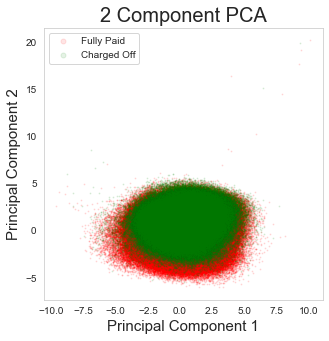

In [181]:
# visualize the PCA
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Principal Component 1", fontsize=15)
ax.set_ylabel("Principal Component 2", fontsize=15)
ax.set_title("2 Component PCA", fontsize=20)

targets = [0, 1]
colors = ["r", "g"]
for target, color in zip(targets, colors):
    indicesToKeep = finalDf["Charged_Off"] == target
    ax.scatter(
        finalDf.loc[indicesToKeep, "principal component 1"],
        finalDf.loc[indicesToKeep, "principal component 2"],
        c=color,
        s=1,
        alpha=0.1,
    )
ax.legend(["Fully Paid", "Charged Off"], markerscale=5.0)
ax.grid()

In [182]:
pca.explained_variance_ratio_

array([0.04416884, 0.04301665])

The explained variance tells us how much information (variance) can be attributed to each of the principal components (~ 0.04)

# 6.6 Linear dependence of Charged-Off

In [178]:
linear_corr = pd.DataFrame()

In [179]:
# Pearson coefficients
for col in X_train.columns:
    linear_corr.loc[col, "pearson_corr"] = X_train[col].corr(y_train)
linear_corr["abs_pearson_corr"] = abs(linear_corr["pearson_corr"])

Sort the results by the absolute value of the Pearson Correlation

In [180]:
linear_corr.sort_values("abs_pearson_corr", ascending=False, inplace=True)
linear_corr.drop("abs_pearson_corr", axis=1, inplace=True)

In [181]:
linear_corr.reset_index(inplace=True)
# linear_corr.rename(columns={'index':'variable'}, inplace=True)

In [182]:
linear_corr.head(10)

,index,pearson_corr
0,int_rate,0.005013
1,earliest_cr_line,0.004391
2,initial_list_status_w,-0.004307
3,purpose_wedding,0.003933
4,mort_acc,0.003478
5,term,0.003120
6,revol_util,0.002944
7,dti,-0.002922
8,sub_grade_A3,0.002569
9,sub_grade_G2,0.002510


In [183]:
linear_corr.tail(10)

,index,pearson_corr
57,sub_grade_F1,-0.000346
58,verification_status_Verified,-0.000286
59,sub_grade_G5,-0.000222
60,sub_grade_D5,-0.000176
61,sub_grade_E1,0.000142
62,sub_grade_D4,-0.000142
63,purpose_debt_consolidation,0.000128
64,sub_grade_F3,0.000117
65,sub_grade_C2,-0.000093
66,purpose_home_improvement,0.000012


In [184]:
df1 = df.copy()

In [185]:
df1[df1.issue_d.between("2016-01-01", "2016-12-31")].sample(10)

,loan_amnt,term,int_rate,emp_length,annual_inc,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,mo_sin_old_il_acct,mort_acc,fico_score,Charged_Off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
1034717,5000.0,36,8.39,1.0,4.740371,2016-03-01,4.73,14.890411,4.0,0.0,3.604658,46.2,64.0,0.0,667.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1067833,16400.0,60,23.13,10.0,4.857339,2016-02-01,26.85,25.232877,13.0,0.0,3.251638,31.9,201.0,0.0,677.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2033671,7000.0,36,16.99,0.0,4.573347,2016-07-01,8.11,13.805479,9.0,0.0,3.792532,86.1,34.0,0.0,672.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2248869,5000.0,36,11.49,8.0,4.744144,2016-10-01,33.21,21.230137,18.0,0.0,3.431203,24.1,206.0,0.0,667.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2169252,20000.0,60,19.99,3.0,5.243041,2016-12-01,25.28,16.558904,11.0,0.0,4.543236,72.6,98.0,1.0,697.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1072269,15075.0,36,12.99,NaN,4.414723,2016-02-01,26.93,15.890411,7.0,0.0,3.905796,80.5,129.0,0.0,697.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2158351,10450.0,36,18.99,10.0,4.863329,2016-12-01,23.89,24.649315,17.0,0.0,4.238673,79.5,93.0,1.0,682.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1085310,3600.0,36,18.99,0.0,4.438273,2016-01-01,15.31,16.808219,7.0,0.0,3.872215,53.2,50.0,0.0,662.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
994714,10000.0,36,12.99,2.0,4.869238,2016-03-01,13.25,25.400000,5.0,0.0,3.630224,73.6,120.0,0.0,677.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2223931,14000.0,36,7.49,10.0,4.979498,2016-11-01,13.70,20.142466,15.0,0.0,4.471277,63.8,39.0,4.0,712.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


This is not as informative as the correlation analysis done earlier, due to the one hot encoding of the categorical features. However, we still get the information that probably the state feature is not that important

# 7. Modeling

* We will implement the ML pipeline with Dimension reduction and the chosen model
* The following models are evaluated, with stratified Kfold cross validation procedure* and grid search.
* Logistic regression with SGD training
* Random Forest
* KNN
* Metrics: AUROC, confusion matrix

As we have an unbalanced dataset problem and we care accuracy of one class over other(false-positives (loans that are fully paid but are predicted to be charged off) are not so bad definitely do not want any false negatives (predicted to be fully paid but eventually charged off)), we could display the class accuracies in confusion matrices.

*We are using Stratified K Fold because there the classes are unbalanced. We do not want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds(if not same).

In [186]:
# CV model with Kfold stratified cross val
kfold = 7
random_state = 42

# 7.1 Logistic Regression with SGD
logistic regression with stochastic gradient descent training.

In [187]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [188]:
pipeline_sgdlr = Pipeline(
    [
        (
            "model",
            SGDClassifier(
                loss="log",
                max_iter=1000,
                tol=1e-3,
                random_state=random_state,
                warm_start=False,
            ),
        )
    ]
)

A small grid of hyper parameters to search over called GridSearchCV. Here we use L1, L2 Regularization!

In [189]:
param_grid_sgdlr = {
    "model__alpha": [10 ** -5, 10 ** -1, 10 ** 2],
    "model__penalty": ["l1", "l2"],
}

In [190]:
grid_sgdlr = GridSearchCV(
    estimator=pipeline_sgdlr,
    param_grid=param_grid_sgdlr,
    scoring="roc_auc",
    n_jobs=-1,
    pre_dispatch="2*n_jobs",
    cv=kfold,
    verbose=1,
    return_train_score=False,
)

Grid search and train the final model on the whole dataset

In [191]:
grid_sgdlr.fit(X_train, y_train)

Fitting 7 folds for each of 6 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:  1.1min finished


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('model',
                                        SGDClassifier(loss='log',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [1e-05, 0.1, 100],
                         'model__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [192]:
sgdlr_estimator = grid_sgdlr.best_estimator_
print("Best score: ", grid_sgdlr.best_score_)
print("Best parameters set: \n", grid_sgdlr.best_params_)

Best score:  0.7110172418708436
Best parameters set: 
 {'model__alpha': 0.1, 'model__penalty': 'l2'}


In [193]:
y_pred_sgdlr = sgdlr_estimator.predict(X_test)
y_prob_sgdlr = sgdlr_estimator.predict_proba(X_test)[:, 1]

In [194]:
y_train_pred_sgdlr = sgdlr_estimator.predict(X_train)
y_train_prob_sgdlr = sgdlr_estimator.predict_proba(X_train)[:, 1]

# Feature Coefficients in the Logistic Regress Model

In [196]:
LRmodel_l2 = SGDClassifier(
    loss="log",
    max_iter=1000,
    tol=1e-3,
    random_state=random_state,
    warm_start=False,
    alpha=0.1,
    penalty="l2",
)

In [197]:
LRmodel_l2.fit(X_train, y_train)

SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [198]:
temp = sorted(
    zip(np.round(LRmodel_l2.coef_.reshape(-1), 3), X_train.columns.values),
    key=lambda x: -abs(x[0]),
)
weight = [x for x, _ in temp]
feature = [x for _, x in temp]

In [199]:
print("Logistic Regression (L2) Coefficients: Top 10")
pd.DataFrame({"weight": weight}, index=feature).head(10)

Logistic Regression (L2) Coefficients: Top 10


,weight
int_rate,0.186
term,0.175
fico_score,-0.111
dti,0.101
annual_inc,-0.074
mort_acc,-0.069
home_ownership_RENT,0.063
loan_amnt,0.059
sub_grade_A2,-0.053
sub_grade_A4,-0.052


From previous Pearson Correlation analysis, the top 6 are: int_rate (0.25), term, fico_score, dti, mort_acc, annul_inc.

Recursive Feature Elimination (RFE)

In [201]:
from sklearn.feature_selection import RFE

rfe_l2 = RFE(
    LRmodel_l2, n_features_to_select=1
)  # If None, half of the features are selected.
rfe_l2.fit(X_train, y_train)

RFE(estimator=SGDClassifier(alpha=0.1, loss='log', random_state=42),
    n_features_to_select=1)

In [202]:
temp = sorted(zip(map(lambda x: round(x, 4), rfe_l2.ranking_), X_train.columns))
rank = [x for x, _ in temp]
feature = [x for _, x in temp]
print("Logistic Regression (L2) RFE Result: Top 10")
pd.DataFrame({"rank": rank}, index=feature).head(10)

Logistic Regression (L2) RFE Result: Top 10


,rank
int_rate,1
term,2
fico_score,3
dti,4
mort_acc,5
annual_inc,6
loan_amnt,7
home_ownership_RENT,8
sub_grade_A2,9
sub_grade_A5,10


Feature coefficients tell us that the top 5 features and their weights in the fitting are: Term (0.18), int_rate(0.156), dti(0.125), fico_score(-0.113), annual_inc(-0.093) while, another way to look at the features, RFE, tells us the top 5 features are: int_rate, term, dti, fico_score, mort_acc. These two methods have slightly different ranks on annual_inc & mort_acct; int_rate & term

# 7.2 Random Forest

In [203]:
from sklearn.ensemble import RandomForestClassifier

In [204]:
rf = RandomForestClassifier(
    n_jobs=4, n_estimators=500, random_state=random_state, max_features="sqrt"
)
param_grid_rf = {
    #'n_estimators': [50, 100],
    "class_weight": [
        {0: 1, 1: 1}
    ],  
}

In [205]:
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    n_jobs=4,
    pre_dispatch="2*n_jobs",
    cv=kfold,
    verbose=1,
    return_train_score=False,
)

In [206]:
grid_rf.fit(X_train, y_train)

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed: 57.0min finished


GridSearchCV(cv=7,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=500, n_jobs=4,
                                              random_state=42),
             n_jobs=4, param_grid={'class_weight': [{0: 1, 1: 1}]},
             scoring='roc_auc', verbose=1)

In [219]:
rf_estimator = grid_rf.best_estimator_
print("Best score: ", grid_rf.best_score_)
print("Best parameters set: \n", grid_rf.best_params_)

Best score:  nan
Best parameters set: 
 {'class_weight': {0: 1, 1: 1}}


In [208]:
y_pred_rf = rf_estimator.predict(X_test)
y_prob_rf = rf_estimator.predict_proba(X_test)[:, 1]

In [209]:
y_train_pred_rf = rf_estimator.predict(X_train)
y_train_prob_rf = rf_estimator.predict_proba(X_train)[:, 1]

Not as good as SDG Logistic regression. Let's check the feature importance.


In [210]:
# Feature importance

In [211]:
names = list(X_train)

In [212]:
feature_importances = pd.DataFrame(
    grid_rf.best_estimator_.feature_importances_,
    index=X_train.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)

In [213]:
print("Features sorted by their score: Top 10")
feature_importances.head(10)

Features sorted by their score: Top 10


,importance
dti,0.087446
int_rate,0.085242
revol_bal,0.082275
revol_util,0.080423
earliest_cr_line,0.080030
mo_sin_old_il_acct,0.076052
annual_inc,0.075718
loan_amnt,0.070045
open_acc,0.058666
fico_score,0.053272


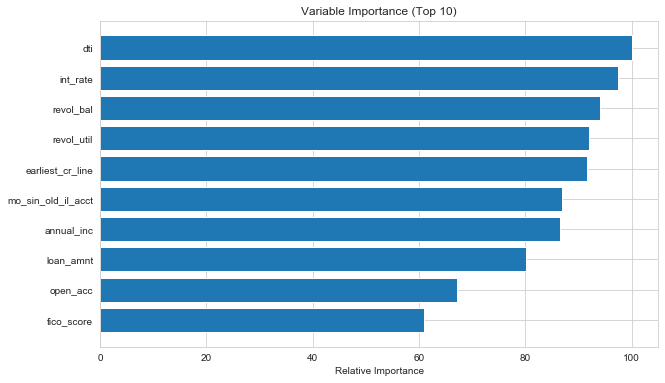

In [214]:
# Normalize The Features and visulize the top 10 features
%matplotlib inline
feature_importance = 100.0 * (
    grid_rf.best_estimator_.feature_importances_
    / grid_rf.best_estimator_.feature_importances_.max()
)
sorted_idx = sorted(
    range(len(feature_importance)), key=lambda i: feature_importance[i]
)[-10:]
pos = np.arange(len(sorted_idx)) + 0.5
plt.figure(figsize=(10, 6))

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.asanyarray(X_train.columns.tolist())[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance (Top 10)")
plt.show()

In [215]:
print("Features sorted by their score: Bottom 10")
feature_importances.tail(10)

Features sorted by their score: Bottom 10


,importance
sub_grade_F5,0.000629
sub_grade_G1,0.000446
purpose_wedding,0.000391
sub_grade_G2,0.000356
sub_grade_G3,0.000270
purpose_renewable_energy,0.000250
sub_grade_G4,0.000213
sub_grade_G5,0.000181
purpose_educational,0.000094
home_ownership_OTHER,0.000072


#  7.3 KNN

In [216]:
We need to reduce the number of the features for KNN (<10) for better performance. This is what normally suggested for KNN to have less than 10 features.

I use LDA for dimension reduction

DecisionTreeClassifier(max_features='sqrt', random_state=1273642419)

In [220]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn import decomposition

In [221]:
# chaining a PCA and a knn
pipeline_knn = Pipeline(
    [("pca", decomposition.PCA()), ("model", KNeighborsClassifier(n_jobs=4))]
)

pipeline_knn2 = Pipeline(
    [("lda", LinearDiscriminantAnalysis()), ("model", KNeighborsClassifier(n_jobs=4))]
)

In [222]:
param_grid_knn = {"pca__n_components": range(3, 6), "model__n_neighbors": [5, 25, 125]}
param_grid_knn2 = {"lda__n_components": range(3, 6), "model__n_neighbors": [5, 25, 125]}

In [223]:
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    n_jobs=4,
    pre_dispatch="2*n_jobs",
    cv=kfold,
    verbose=1,
    return_train_score=False,
)

In [226]:
grid_knn.fit(X_train, y_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done  63 out of  63 | elapsed:  7.2min finished


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('model',
                                        KNeighborsClassifier(n_jobs=4))]),
             n_jobs=4,
             param_grid={'model__n_neighbors': [5, 25, 125],
                         'pca__n_components': range(3, 6)},
             scoring='roc_auc', verbose=1)

In [227]:
knn_estimator = grid_knn.best_estimator_
print("Best score: ", grid_knn2.best_score_)
print("Best parameters set: \n", grid_knn.best_params_)

Best score:  nan
Best parameters set: 
 {'model__n_neighbors': 125, 'pca__n_components': 4}


In [229]:
y_pred_knn = knn_estimator.predict(X_test)
y_prob_knn = knn_estimator.predict_proba(X_test)[:, 1]

In [231]:
y_train_pred_knn = knn_estimator.predict(X_train)
y_train_prob_knn = knn_estimator.predict_proba(X_train)[:, 1]

# 7.4 Gradient Boosting Classifier

In [247]:
def run_models(X_train, y_train, X_test, y_test, model_type="Non-balanced"):

    param_test1 = {"n_estimators": range(20, 81, 10)}
    clf = GridSearchCV(
        estimator=GradientBoostingClassifier(
            learning_rate=0.1,
            min_samples_split=500,
            min_samples_leaf=50,
            max_depth=8,
            max_features="sqrt",
            subsample=0.8,
            random_state=10,
        ),
        param_grid=param_test1,
        scoring="roc_auc",
        n_jobs=4,
        iid=False,
        cv=5,
    )

    cols = [
        "model",
        "matthews_corrcoef",
        "roc_auc_score",
        "precision_score",
        "recall_score",
        "f1_score",
    ]

    models_report = pd.DataFrame(columns=cols)
    conf_matrix = dict()

    #     for clf, clf_name in zip(param_test1.values(), param_test1.keys()):

    clf.fit(X_train, y_train)
    clf_name = GradientBoostingClassifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    print("computing {} - {} ".format(clf_name, model_type))

    tmp = pd.Series(
        {
            "model_type": model_type,
            "model": clf_name,
            "roc_auc_score": metrics.roc_auc_score(y_test, y_score),
            "matthews_corrcoef": metrics.matthews_corrcoef(y_test, y_pred),
            "precision_score": metrics.precision_score(y_test, y_pred),
            "recall_score": metrics.recall_score(y_test, y_pred),
            "f1_score": metrics.f1_score(y_test, y_pred),
        }
    )

    models_report = models_report.append(tmp, ignore_index=True)
    conf_matrix[clf_name] = pd.crosstab(
        y_test, y_pred, rownames=["True"], colnames=["Predicted"], margins=False
    )
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, y_score, drop_intermediate=False, pos_label=1
    )

    plt.figure(1, figsize=(6, 6))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC curve - {}".format(model_type))
    plt.plot(fpr, tpr, label=clf_name)
    plt.legend(loc=2, prop={"size": 11})
    plt.plot([0, 1], [0, 1], color="black")

    return models_report, conf_matrix, clf

computing <class 'sklearn.ensemble._gb.GradientBoostingClassifier'> - Non-balanced 


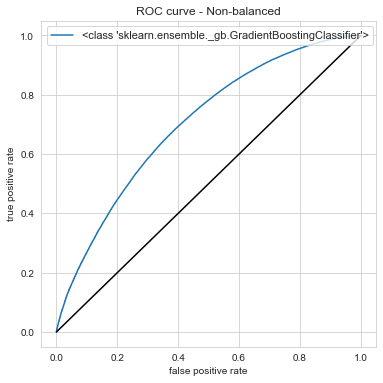

In [248]:
models_report, conf_matrix, grid_gb = run_models(
    X_train, y_train, X_test, y_test, model_type="Non-balanced"
)

In [250]:
models_report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,<class 'sklearn.ensemble._gb.GradientBoostingC...,0.157476,0.702171,0.504246,0.113549,0.185358,Non-balanced


In [251]:
grid_gb

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 81, 10)}, scoring='roc_auc')

In [252]:
gb_estimator = grid_gb.best_estimator_
print("Best score: ", grid_gb.best_score_)
print("Best parameters set: \n", grid_gb.best_params_)

Best score:  0.7156102795843665
Best parameters set: 
 {'n_estimators': 80}


In [253]:
y_pred_gb = gb_estimator.predict(X_test)
y_prob_gb = gb_estimator.predict_proba(X_test)[:, 1]

In [254]:
y_train_pred_gb = gb_estimator.predict(X_train)
y_train_prob_gb = gb_estimator.predict_proba(X_train)[:, 1]

# 7.5 Model Comparison & Evaluation

,AUROC,Algorithm
0,0.711017,SGD Logistic Regression
1,NaN,RandomForest
2,0.696943,KNeighboors
3,0.715610,GradientBoosting


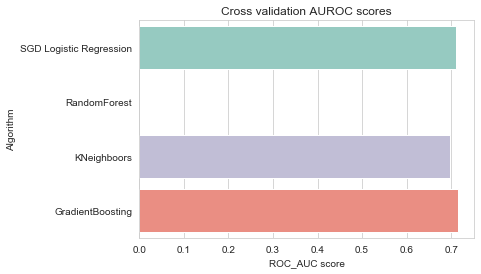

In [249]:
auroc_means = [
    grid_sgdlr.best_score_,
    grid_rf.best_score_,
    grid_knn.best_score_,
    grid_gb.best_score_,
]
auroc_res = pd.DataFrame(
    {
        "AUROC": auroc_means,
        "Algorithm": [
            "SGD Logistic Regression",
            "RandomForest",
            "KNeighboors",
            "GradientBoosting",
        ],
    }
)

g = sns.barplot("AUROC", "Algorithm", data=auroc_res, palette="Set3", orient="h")
g.set_xlabel("ROC_AUC score")
g = g.set_title("Cross validation AUROC scores")
auroc_res

In [232]:
y_prob_knn

array([0.056, 0.12 , 0.144, ..., 0.256, 0.272, 0.352])

In [233]:
y_train_prob_knn 

array([0.168, 0.168, 0.144, ..., 0.192, 0.192, 0.104])

In [236]:
def evaluation(
    X_train, X_test, Y_train, Y_test, Y_train_pred, Y_train_prob, Y_pred, Y_prob
):
    print("--- ROC AUC ---")
    print("Training Set:", roc_auc_score(Y_train, Y_train_prob))
    print("Test Set:", roc_auc_score(Y_test, Y_prob))

    print("\n--- Accuracy ---")
    print("Training Set:", accuracy_score(Y_train, Y_train_pred))
    print("Test Set:", accuracy_score(Y_test, Y_pred))

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    print("\n--- Confusion Matrix ---")
    print("True Positive:", tp)
    print("False Negative:", fn)
    print("True Negative:", tn)
    print("False Positive:", fp)

    print("\n--- Precision ---")
    print("Training Set:", precision_score(Y_train, Y_train_pred))
    print("Test Set:", precision_score(Y_test, Y_pred))

    print("\n--- Recall ---")
    print("Training Set:", recall_score(Y_train, Y_train_pred))
    print("Test Set:", recall_score(Y_test, Y_pred))

    print("\n--- F1 Score ---")
    print("Training Set:", f1_score(Y_train, Y_train_pred))
    print("Test Set:", f1_score(Y_test, Y_pred))

def plot_ROC(X_test, Y_test, Y_prob):

    # Y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = roc_curve(Y_test, Y_prob, pos_label=1)
    roc_auc = roc_auc_score(Y_test, Y_prob)
    # These are the points at threshold = 0.1~0.5
    x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)]
    x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

    fig = plt.figure()
    plt.plot(fpr, tpr, color="r", lw=2)
    plt.plot([0, 1], [0, 1], color="b", lw=2, linestyle="--")
    plt.plot(x1, x2, color="k", lw=3, label="threshold = 0.1 ~ 0.5")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Area = {:.2f})".format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()

===== Logistic Regression =====
--- ROC AUC ---
Training Set: 0.7119243407947724
Test Set: 0.6932184288527243

--- Accuracy ---
Training Set: 0.8064466939138194
Test Set: 0.7821839567958832

--- Confusion Matrix ---
True Positive: 2609
False Negative: 59100
True Negative: 218699
False Positive: 2528

--- Precision ---
Training Set: 0.624390243902439
Test Set: 0.5078839789760561

--- Recall ---
Training Set: 0.014851341551849166
Test Set: 0.042279084088220516

--- F1 Score ---
Training Set: 0.029012608018132876
Test Set: 0.07806001855010022


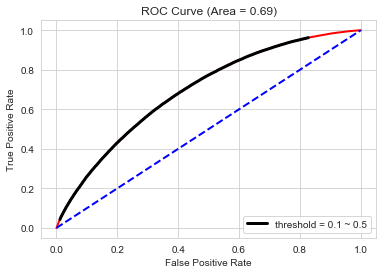

In [237]:
print("===== Logistic Regression =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_sgdlr,
    y_train_prob_sgdlr,
    y_pred_sgdlr,
    y_prob_sgdlr,
)
plot_ROC(X_test, y_test, y_prob_sgdlr)

===== KNN =====
--- ROC AUC ---
Training Set: 0.7156782214983524
Test Set: 0.6843587428733914

--- Accuracy ---
Training Set: 0.8077560256557483
Test Set: 0.7818587949218198

--- Confusion Matrix ---
True Positive: 4343
False Negative: 57366
True Negative: 216873
False Positive: 4354

--- Precision ---
Training Set: 0.5674212344660444
Test Set: 0.49936759802230657

--- Recall ---
Training Set: 0.053197969543147205
Test Set: 0.07037871299162196

--- F1 Score ---
Training Set: 0.09727593781907065
Test Set: 0.12337016731528563


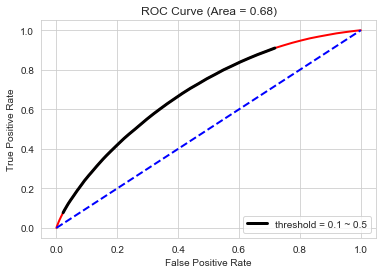

In [238]:
print("===== KNN =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_knn,
    y_train_prob_knn,
    y_pred_knn,
    y_prob_knn,
)
plot_ROC(X_test, y_test, y_prob_knn)

===== Random Forest =====
--- ROC AUC ---
Training Set: 1.0
Test Set: 0.6949581937038756

--- Accuracy ---
Training Set: 1.0
Test Set: 0.7826151497158368

--- Confusion Matrix ---
True Positive: 5719
False Negative: 55990
True Negative: 215711
False Positive: 5516

--- Precision ---
Training Set: 1.0
Test Set: 0.5090342679127726

--- Recall ---
Training Set: 1.0
Test Set: 0.09267691908797744

--- F1 Score ---
Training Set: 1.0
Test Set: 0.1568052204430796


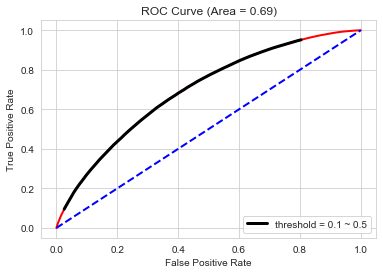

In [243]:
print("===== Random Forest =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_rf,
    y_train_prob_rf,
    y_pred_rf,
    y_prob_rf,
)
plot_ROC(X_test, y_test, y_prob_rf)

===== Gradient Boosting =====
--- ROC AUC ---
Training Set: 0.7284305275494277
Test Set: 0.7021706886714325

--- Accuracy ---
Training Set: 0.8107116702780753
Test Set: 0.7823147284191478

--- Confusion Matrix ---
True Positive: 7007
False Negative: 54702
True Negative: 214338
False Positive: 6889

--- Precision ---
Training Set: 0.5932950750575495
Test Set: 0.5042458261370178

--- Recall ---
Training Set: 0.0884650713077109
Test Set: 0.11354907712003111

--- F1 Score ---
Training Set: 0.15397171982346977
Test Set: 0.18535811123602935


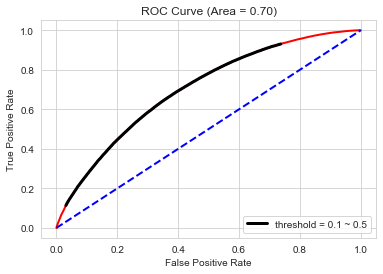

In [256]:
print("===== Gradient Boosting =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_gb,
    y_train_prob_gb,
    y_pred_gb,
    y_prob_gb,
)
plot_ROC(X_test, y_test, y_prob_gb)

In order to compare the profitability of my model and the profitability the bank actually made (for the test set), I assume:

* If the loan is granted and the it doesn't get repaid, we lose 1
* If the loan is granted and the it does get repaid, we gain 1
* We gain 0 if the loan is not granted

In [244]:
# bank
score_bank = sum(y_test == 0) - sum(y_test == 1)

# my Logistic regression model
tn, fp, fn, tp = confusion_matrix(y_test, grid_sgdlr.predict(X_test)).ravel()
score_lr = tn - fn

print("The bank scores {} points".format(score_bank))
print("The Logistic regression model scores {} points".format(score_lr))

The bank scores 159518 points
The Logistic regression model scores 159599 points


In [246]:
score_bank = sum(y_test == 0) - sum(y_test == 1)

# my Logistic regression model
tn, fp, fn, tp = confusion_matrix(y_test, grid_knn.predict(X_test)).ravel()
score_gb = tn - fn

print("The bank scores {} points".format(score_bank))
print("The Logistic regression model scores {} points".format(score_gb))

The bank scores 159518 points
The Logistic regression model scores 159507 points


# 8. Conclusion

We applied ML to predict the probability that a requested loan on LendingCLub will be charged off. After training with 3 models (Logistic Regression, random forest, KNN), We found that the Gradient Boosting classifier performs the best (highest AUROC score of ~0.2) and the score on the testing dataset is slightly lower at --.

According to the Pearson correlation between the features and the target variable, the most important features for prediction Charged-off are interest rate, term, debt-to-income ratio, and FICO score.